## Projet 5 : Segmentez des clients d'un site e-commerce

## Contexte

Vous êtes consultant pour Olist, une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.

Votre rôle est d’accompagner Olist dans leur projet de monter une équipe Data et leur premier cas d’usage Data Science autour de la segmentation client.

Première urgence : l'implémentation de requêtes SQL urgentes.

Deuxième urgence :  fournir aux équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Vous devrez fournir à l’équipe Marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

## Librairies utilisées avec le langage Python:

In [1]:
# Importation des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import sqlite3
# from IPython.display import Image
# from sklearn.preprocessing import LabelEncoder # sklearn preprocessing for dealing with categorical variables
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
# from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.model_selection import train_test_split
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
 # Fonction permettant de visualiser le pourcentage de valeurs manquantes par variables

def show_miss_val(data):
    variables = []
    miss_val = []

    for item in data.columns:
        variables.append(item)
        miss_val.append(data[item].isna().mean()) #Calcul du pourcentage de valeurs manquantes

    # Création d'un dataframe avec le résultat
    output = pd.DataFrame({
        'variable': variables,
        'miss_val': miss_val
    })
    # Affichage d'un message récapitulant le nombre de variables et le nombre d'entre elles qui a des valeurs manquantes
    print ("Notre dataframe a " + str(data.shape[1]) + " variables.\n Il y a " + str(output[output['miss_val']!=0].shape[0]) +" variables contenant des valeurs manquantes.")

    # Retourne les colonnes qui ont des valeurs manquantes avec le pourcentage de valeurs manquantes de chacune d'entre elles
    return output[output['miss_val']!=0].sort_values('miss_val')

In [3]:
def pd_to_sqlDB(input_df: pd.DataFrame,
                table_name: str,
                db_name: str = 'default.db') -> None:

    '''Take a Pandas dataframe `input_df` and upload it to `table_name` SQLITE table
    Args:
        input_df (pd.DataFrame): Dataframe containing data to upload to SQLITE
        table_name (str): Name of the SQLITE table to upload to
        db_name (str, optional): Name of the SQLITE Database in which the table is created.
                                 Defaults to 'default.db'.
    '''

    # Step 1: Setup local logging
    import logging
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s %(levelname)s: %(message)s',
                        datefmt='%Y-%m-%d %H:%M:%S')

    # Step 2: Find columns in the dataframe
    cols = input_df.columns
    cols_string = ','.join(cols)
    val_wildcard_string = ','.join(['?'] * len(cols))

    # Step 3: Connect to a DB file if it exists, else crete a new file
    con = sqlite3.connect(db_name)
    cur = con.cursor()
    logging.info(f'SQL DB {db_name} created')

    # Step 4: Create Table
    sql_string = f"""CREATE TABLE {table_name} ({cols_string});"""
    cur.execute(sql_string)
    logging.info(f'SQL Table {table_name} created with {len(cols)} columns')

    # Step 5: Upload the dataframe
    rows_to_upload = input_df.to_dict(orient='split')['data']
    sql_string = f"""INSERT INTO {table_name} ({cols_string}) VALUES ({val_wildcard_string});"""
    cur.executemany(sql_string, rows_to_upload)
    logging.info(f'{len(rows_to_upload)} rows uploaded to {table_name}')

    # Step 6: Commit the changes and close the connection
    con.commit()
    con.close()

In [4]:
def sql_query_to_pd(sql_query_string: str, db_name: str ='default.db') -> pd.DataFrame:
    '''Execute an SQL query and return the results as a pandas dataframe
    Args:
        sql_query_string (str): SQL query string to execute
        db_name (str, optional): Name of the SQLITE Database to execute the query in.
                                 Defaults to 'default.db'.
    Returns:
        pd.DataFrame: Results of the SQL query in a pandas dataframe
    '''
    # Step 1: Connect to the SQL DB
    con = sqlite3.connect(db_name)

    # Step 2: Execute the SQL query
    cursor = con.execute(sql_query_string)

    # Step 3: Fetch the data and column names
    result_data = cursor.fetchall()
    cols = [description[0] for description in cursor.description]

    # Step 4: Close the connection
    con.close()

    # Step 5: Return as a dataframe
    return pd.DataFrame(result_data, columns=cols)

## Clustering RFM :


Pour effectuer le clustering selon les variables RFM (standard du ciblage marketing), nous agrègerons les données par client et non pas par commande dans un premier temps, puis nous créerons ces variables RFM (Récence, Fréquence, Montant) par client.

In [5]:
# Chargement des données brutes du fichier CSV
data_fe = pd.read_csv('/tutorial-env/OCR/Projet5/data_fe.csv')
data_fe_client = pd.read_csv('/tutorial-env/OCR/Projet5/data_fe_client.csv')

In [6]:
pd_to_sqlDB(data_fe,
            table_name='data_fe_CL',
            db_name='/tutorial-env/OCR/Projet5/olist.db')

sql_query_string = """
SELECT customer_unique_id,COUNT(order_id) AS Frequence,julianday(date('now')) - julianday(MAX(order_purchase_date)) AS recence,SUM(payment_total) AS montant
FROM data_fe_CL
GROUP BY 1
ORDER BY 1
"""

df_temp=sql_query_to_pd(sql_query_string, db_name='/tutorial-env/OCR/Projet5/olist.db')

2024-09-09 13:04:56 INFO: SQL DB /tutorial-env/OCR/Projet5/olist.db created
2024-09-09 13:04:56 INFO: SQL Table data_fe_CL created with 17 columns
2024-09-09 13:05:00 INFO: 99441 rows uploaded to data_fe_CL


In [7]:
# Création du dataframe RFM :
data_rfm = pd.DataFrame(df_temp)

In [8]:
data_rfm.describe()

,Frequence,recence,montant
count,96096.000000,96096.000000,96095.000000
mean,1.034809,2442.108797,166.594226
std,0.214384,153.417869,231.428912
min,1.000000,2154.000000,0.000000
25%,1.000000,2318.000000,63.120000
50%,1.000000,2423.000000,108.000000
75%,1.000000,2551.000000,183.530000
max,17.000000,2927.000000,13664.080000


### Analyse des variables :

Analysons maintenant les variables RFM :

In [9]:
def describe_data_quant(data, col):
    data_des = data.describe()
    df = pd.DataFrame({'Caractéristiques': data_des[col].index,
                           'Valeurs': data_des[col].values
                           })

    sns.set_style("whitegrid")
    ax = sns.boxplot(x=data[col])


    plt.figure(figsize=(9, 8))
    sns.distplot(data[col], color='blue', kde=True)
    plt.title(f'Distribution de {col}')
    plt.ylabel("Fréquence de la donnée")
    plt.grid()
    plt.show()

    return df.style.set_caption(f'Caractéristiques {col}')

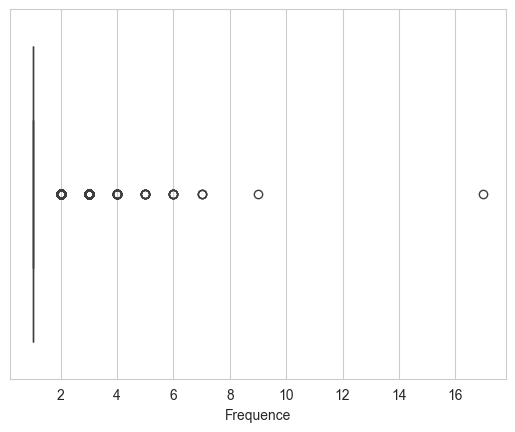

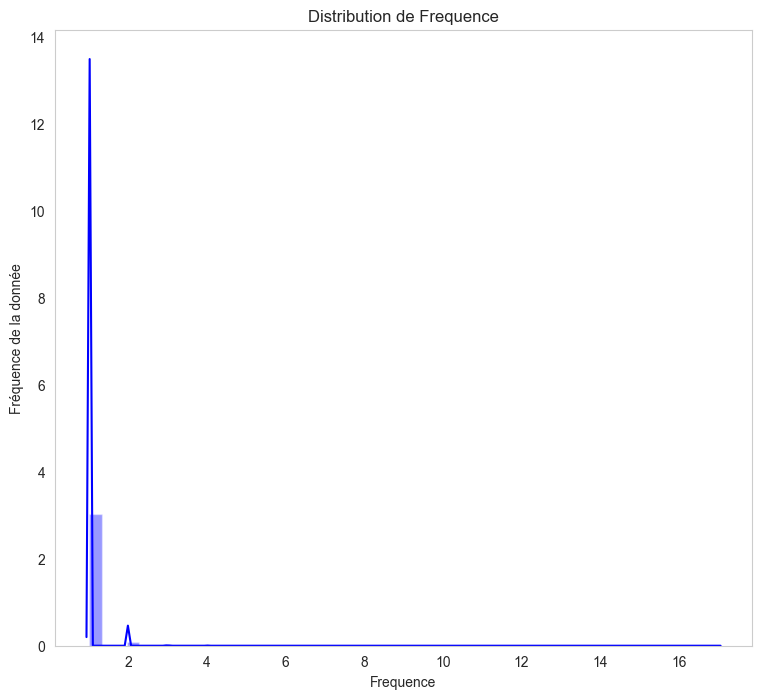

,Caractéristiques,Valeurs
0,count,96096.000000
1,mean,1.034809
2,std,0.214384
3,min,1.000000
4,25%,1.000000
5,50%,1.000000
6,75%,1.000000
7,max,17.000000


In [10]:
describe_data_quant(data_rfm, 'Frequence')

Quasiment la totalité des fréquences sont égales à 1 donc cette variable ne devrait pas aider pour le clustering.

Faisons une transformation racine carrée de cette variable :

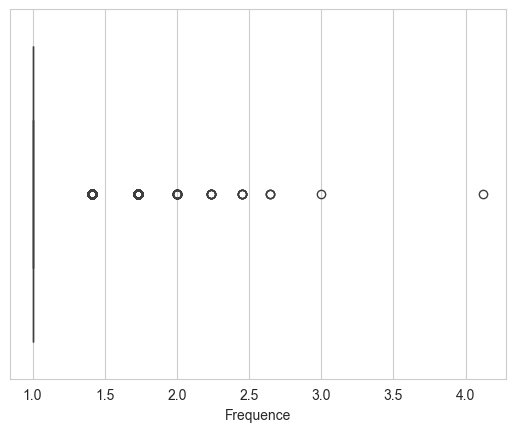

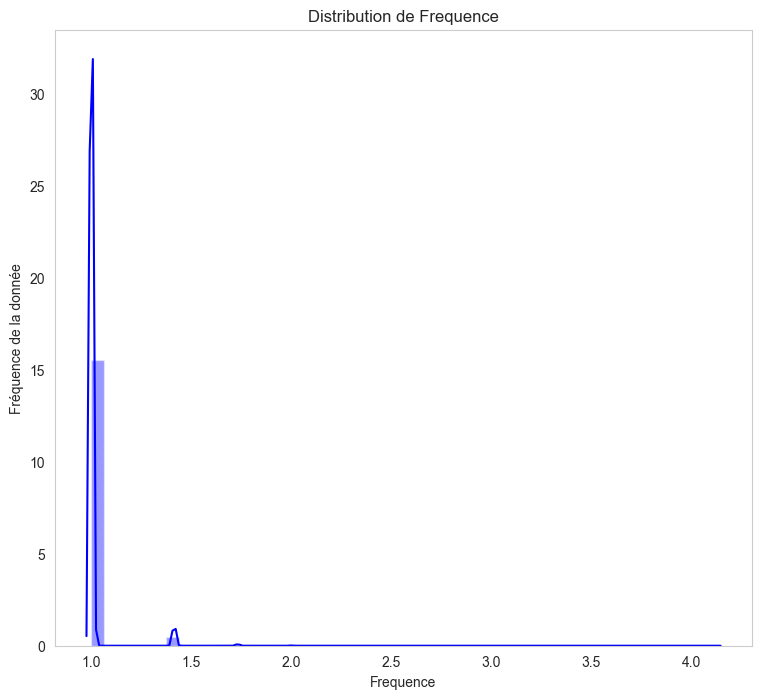

,Caractéristiques,Valeurs
0,count,96096.000000
1,mean,1.013989
2,std,0.081460
3,min,1.000000
4,25%,1.000000
5,50%,1.000000
6,75%,1.000000
7,max,4.123106


In [11]:
# Création d'un dataframe après transformation en racine carré
data_rfm_sqrt = pd.DataFrame()
data_rfm_sqrt['Frequence']= np.sqrt(data_rfm['Frequence'])

describe_data_quant(data_rfm_sqrt, 'Frequence')

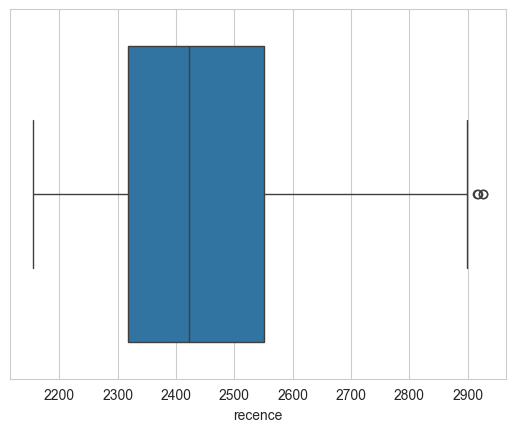

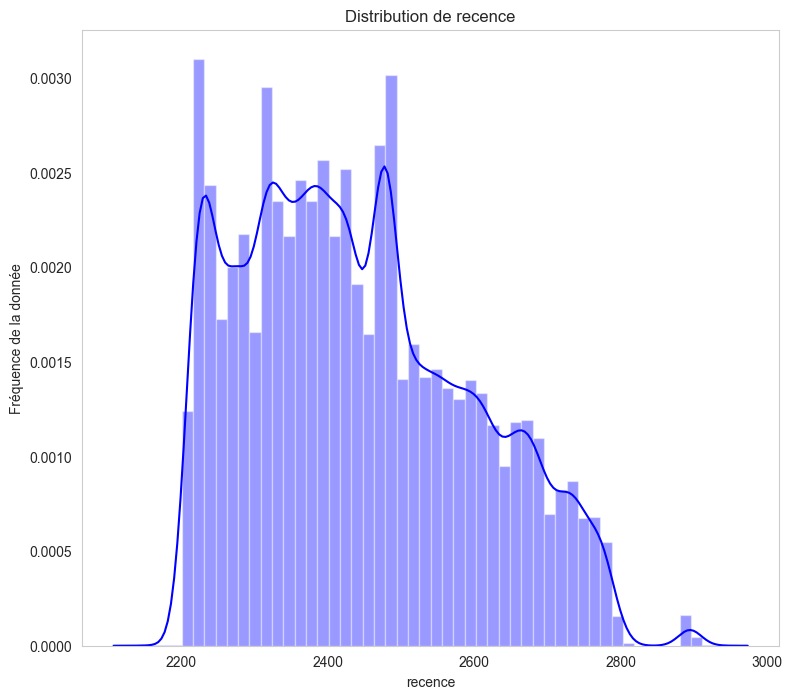

,Caractéristiques,Valeurs
0,count,96096.000000
1,mean,2442.108797
2,std,153.417869
3,min,2154.000000
4,25%,2318.000000
5,50%,2423.000000
6,75%,2551.000000
7,max,2927.000000


In [12]:
data_rfm_sqrt['recence']= data_rfm['recence']
describe_data_quant(data_rfm, 'recence')

La variable "recence" a plus de variance et pourra être potentiellement utile pour le clustering.

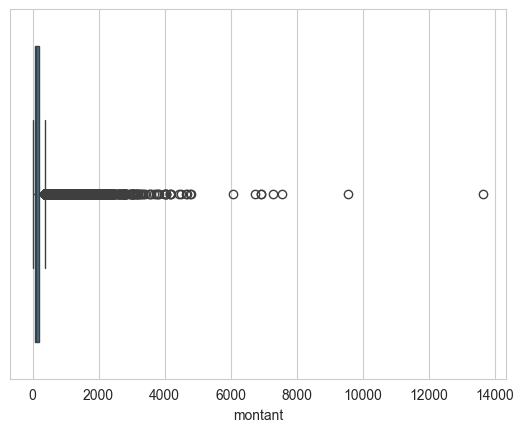

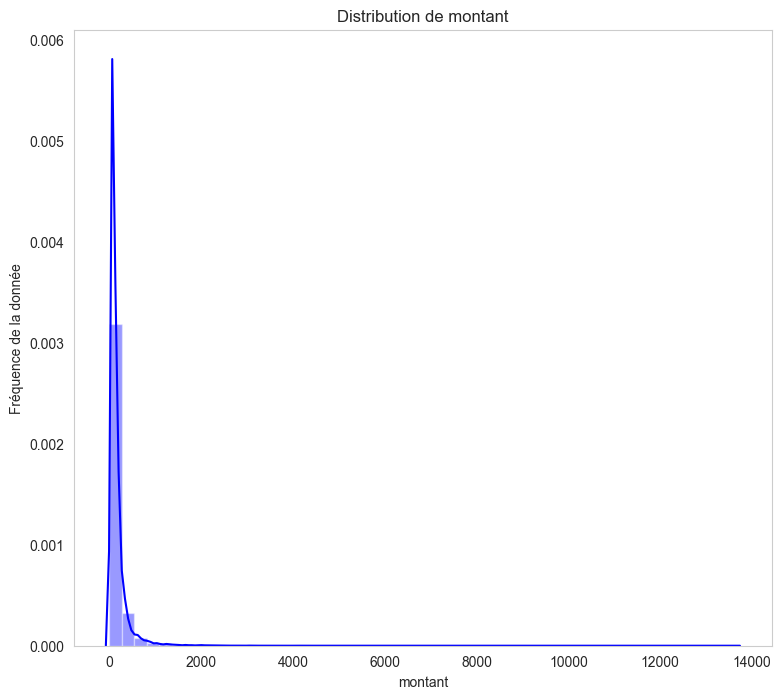

,Caractéristiques,Valeurs
0,count,96095.000000
1,mean,166.594226
2,std,231.428912
3,min,0.000000
4,25%,63.120000
5,50%,108.000000
6,75%,183.530000
7,max,13664.080000


In [13]:
describe_data_quant(data_rfm, 'montant')

La variable "montant" a plus de variance et pourra être potentiellement utile pour le clustering.

Faisons une transformation racine carrée de cette variable :

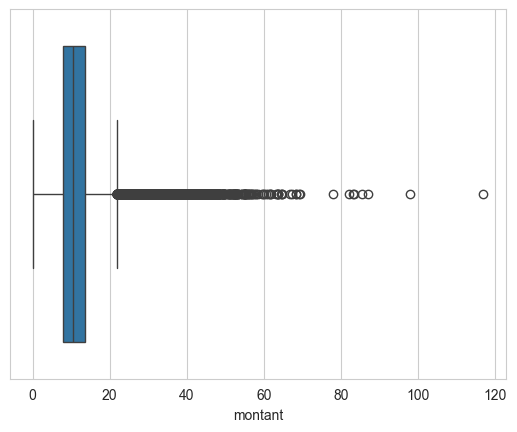

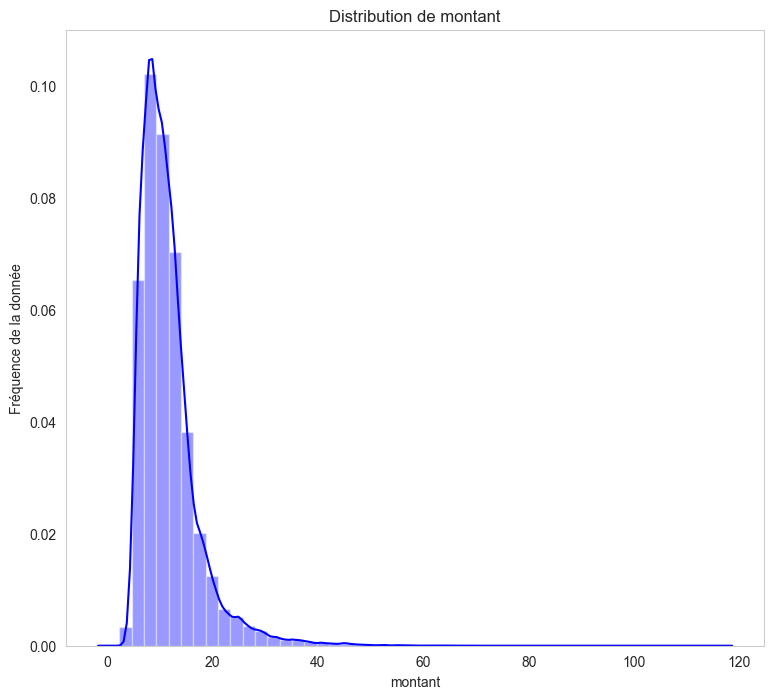

,Caractéristiques,Valeurs
0,count,96095.000000
1,mean,11.602458
2,std,5.654868
3,min,0.000000
4,25%,7.944810
5,50%,10.392305
6,75%,13.547324
7,max,116.893456


In [14]:
data_rfm_sqrt['montant']= np.sqrt(data_rfm['montant'])

describe_data_quant(data_rfm_sqrt, 'montant')

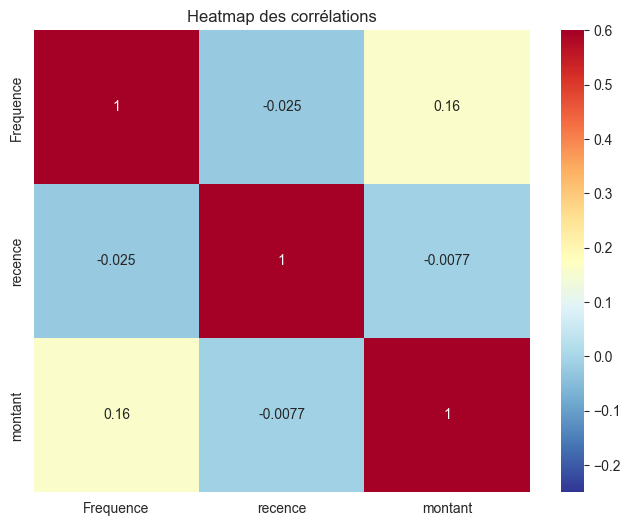

In [15]:
plt.figure(figsize = (8, 6))
data_corr = data_rfm_sqrt.select_dtypes(include=['float', 'int64'])
# Heatmap des correlations
sns.heatmap(data_corr.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Heatmap des corrélations');

Il n'y a pas de corrélations entre ces trois variables, ce qui est important pour le clustering.

In [16]:
#  Appel de la fonction affichant le pourcentage de valeur manquantes par variable
data_rfm_vm=show_miss_val(data_rfm_sqrt)
data_rfm_vm.head(26)

Notre dataframe a 3 variables.
 Il y a 1 variables contenant des valeurs manquantes.


,variable,miss_val
2,montant,0.00001


Il y a très peu de valeurs manquantes mais nous allons quand même imputer par la médiane pour que l'ensemble du jeu de données puisse être utilisé dans le clustering.

In [17]:
# Créer une instance de SimpleImputer
imputer = SimpleImputer(strategy='median')
# Remodeler la colonne en un tableau 2D
data_temp = data_rfm_sqrt['montant'].values.reshape(-1, 1)
data_rfm_sqrt['montant'] = imputer.fit_transform(data_temp)


In [18]:
#  Appel de la fonction affichant le pourcentage de valeur manquantes par variable
data_rfm_vm=show_miss_val(data_rfm_sqrt)
data_rfm_vm.head(26)

Notre dataframe a 3 variables.
 Il y a 0 variables contenant des valeurs manquantes.


,variable,miss_val


Nous avons imputé toutes les valeurs manquantes par la médiane, enlevons la
colonne avec les identifiants clients et normalisons maintenant notre dataframe :

In [19]:
# Créer une instance de Standardscaler
scaler = StandardScaler()

# Normalisation des données
data_rfm_norm = pd.DataFrame(scaler.fit_transform(data_rfm_sqrt),columns=data_rfm_sqrt.columns)

data_rfm_norm.describe(include="all")

,Frequence,recence,montant
count,9.609600e+04,9.609600e+04,9.609600e+04
mean,3.941051e-16,-9.973892e-16,1.311712e-16
std,1.000005e+00,1.000005e+00,1.000005e+00
min,-1.717273e-01,-1.877945e+00,-2.051783e+00
25%,-1.717273e-01,-8.089634e-01,-6.468183e-01
50%,-1.717273e-01,-1.245546e-01,-2.140019e-01
75%,-1.717273e-01,7.097724e-01,3.439336e-01
max,3.816767e+01,3.160608e+00,1.861972e+01


### KMeans avec 3 clusters :

Faisons maintenant le clustering avec l'algorithme du K-means car c'est le modèle non-supervisé le plus simple à utiliser, et le plus rapide à entraîner. Il est donc le modèle le plus adapté pour notre problématique. De plus, nous pouvons choisir explicitement le nombre de clusters.

Ce modèle n'est pas adapté aux clusters de topologie complexe.

In [20]:
kmeans = KMeans(init='k-means++',n_clusters=3,n_init=10,max_iter=300, random_state=42)

kmeans.fit(data_rfm_norm)

# Ajout des labels de cluster au dataframe
data_rfm_norm['cluster'] = kmeans.labels_

In [21]:
data_rfm_norm

,Frequence,recence,montant,cluster
0,-0.171727,-0.835036,0.054773,1
1,-0.171727,-0.815482,-1.129665,1
2,-0.171727,1.941708,-0.409735,0
3,-0.171727,0.533782,-0.883832,0
4,-0.171727,0.318682,0.429600,0
...,...,...,...,...
96091,-0.171727,1.355072,5.988962,0
96092,-0.171727,0.149209,-0.425427,0
96093,-0.171727,2.143772,-0.176439,0
96094,-0.171727,-0.782891,-0.007075,1


In [22]:
# Ajout de la colonne "cluster" au jeu de données RFM :
data_rfm_cluster = data_rfm.merge(data_rfm_norm['cluster'],left_index=True, right_index=True, how='left')
data_rfm_cluster

,customer_unique_id,Frequence,recence,montant,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2314.0,141.90,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2317.0,27.19,1
2,0000f46a3911fa3c0805444483337064,1,2740.0,86.22,0
3,0000f6ccb0745a6a4b88665a16c9f078,1,2524.0,43.62,0
4,0004aac84e0df4da2b147fca70cf8255,1,2491.0,196.89,0
...,...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,1,2650.0,2067.42,0
96092,fffea47cd6d3cc0a88bd621562a9d061,1,2465.0,84.58,0
96093,ffff371b4d645b6ecea244b27531430a,1,2771.0,112.46,0
96094,ffff5962728ec6157033ef9805bacc48,1,2322.0,133.69,1


In [23]:
# Ajout de la colonne "cluster" au jeu de données issu du feature engineering et supression des variables doublons:
data_fe_cluster = data_fe_client.merge(data_rfm_cluster, on='customer_unique_id', how='left')
cols_to_drop = ["COUNT(order_id)", "SUM(payment_total)"]
data_fe_cluster = data_fe_cluster.drop(cols_to_drop, axis=1)
data_fe_cluster

,customer_unique_id,AVG(estimated_delivery_delay),AVG(true_delivery_delay),AVG(late_delivery),SUM(price),SUM(freight_value),AVG(payment_payment_installments),AVG(review_score_moy),Frequence,recence,montant,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,11.0,6.0,-5.0,129.90,12.00,8.0,5.0,1,2314.0,141.90,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,8.0,3.0,-5.0,18.90,8.29,1.0,4.0,1,2317.0,27.19,1
2,0000f46a3911fa3c0805444483337064,28.0,26.0,-2.0,69.00,17.22,8.0,3.0,1,2740.0,86.22,0
3,0000f6ccb0745a6a4b88665a16c9f078,32.0,20.0,-12.0,25.99,17.63,4.0,4.0,1,2524.0,43.62,0
4,0004aac84e0df4da2b147fca70cf8255,21.0,13.0,-8.0,180.00,16.89,6.0,5.0,1,2491.0,196.89,0
...,...,...,...,...,...,...,...,...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,55.0,28.0,-27.0,680.00,239.14,10.0,5.0,1,2650.0,2067.42,0
96092,fffea47cd6d3cc0a88bd621562a9d061,33.0,30.0,-3.0,64.89,19.69,1.0,4.0,1,2465.0,84.58,0
96093,ffff371b4d645b6ecea244b27531430a,45.0,15.0,-30.0,89.90,22.56,1.0,5.0,1,2771.0,112.46,0
96094,ffff5962728ec6157033ef9805bacc48,26.0,12.0,-14.0,115.00,18.69,5.0,5.0,1,2322.0,133.69,1


Regardons les heatmap de corrélations pour chaque clusters afin de voir si des différences existent entre eux :

In [24]:
df_cluster_0 = data_fe_cluster[data_fe_cluster['cluster'] == 0.0]
df_cluster_1 = data_fe_cluster[data_fe_cluster['cluster'] == 1.0]
df_cluster_2 = data_fe_cluster[data_fe_cluster['cluster'] == 2.0]

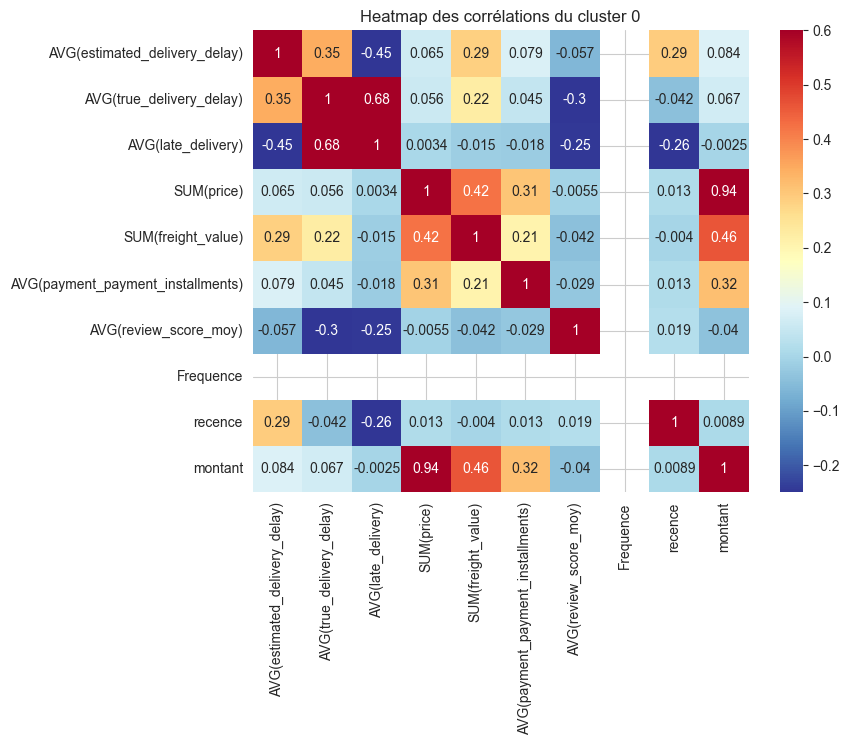

In [25]:
#  Corrélation entre le cluster 0 et le dataframe data_fe_client
plt.figure(figsize = (8, 6))

data_corr = df_cluster_0.select_dtypes(include=['float', 'int64'])
# Heatmap des correlations
sns.heatmap(data_corr.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Heatmap des corrélations du cluster 0');

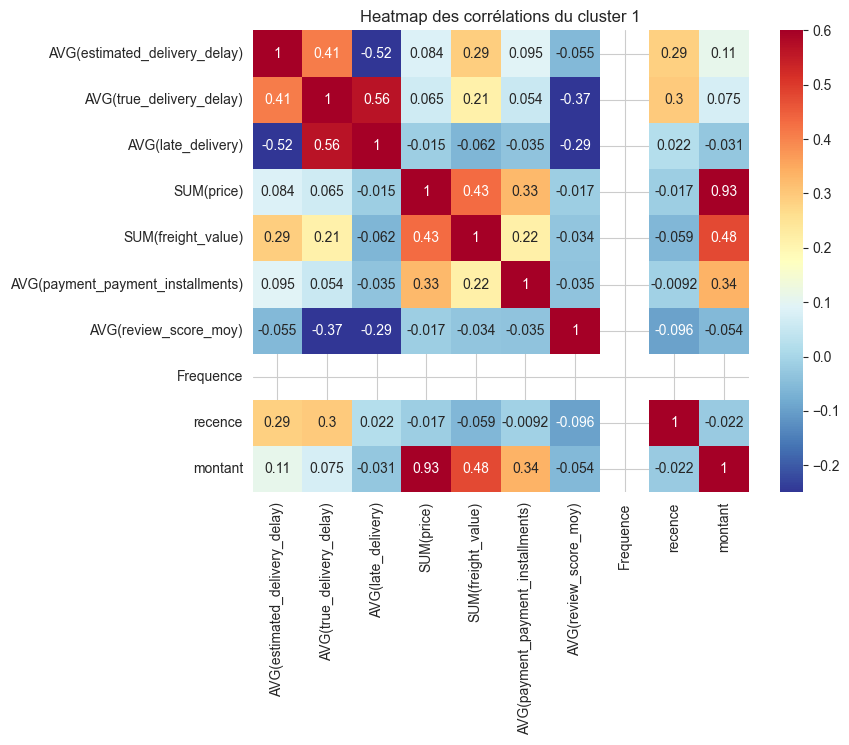

In [26]:
#  Corrélation entre le cluster 1 et le dataframe data_fe_client
plt.figure(figsize = (8, 6))

data_corr = df_cluster_1.select_dtypes(include=['float', 'int64'])
# Heatmap des correlations
sns.heatmap(data_corr.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Heatmap des corrélations du cluster 1');

Text(0.5, 1.0, 'Heatmap des corrélations du cluster 2')

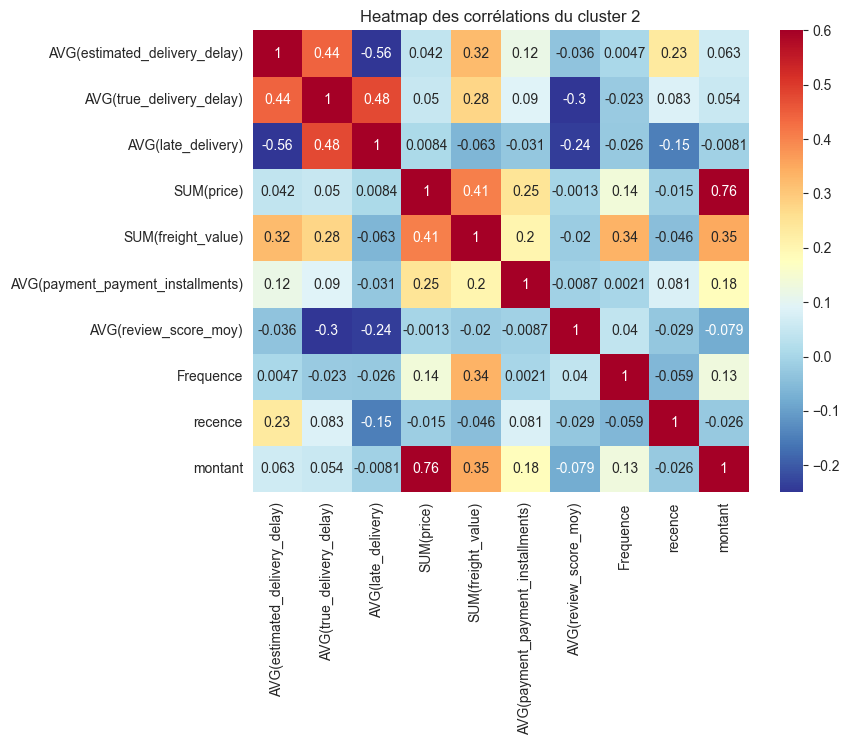

In [27]:
#  Corrélation entre le cluster 2 et le dataframe data_fe_client
plt.figure(figsize = (8, 6))

data_corr = df_cluster_2.select_dtypes(include=['float', 'int64'])
# Heatmap des correlations
sns.heatmap(data_corr.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Heatmap des corrélations du cluster 2')

On visualise que seul le cluster 2 a des fréquences différentes de 0. Il correspond donc à des clients qui ont effectués plusieurs achats contrairement aux clusters 0 et 1 qui n'en ont effectués qu'un seul.

Les autres corrélations sont proches entre les 3 clusters.

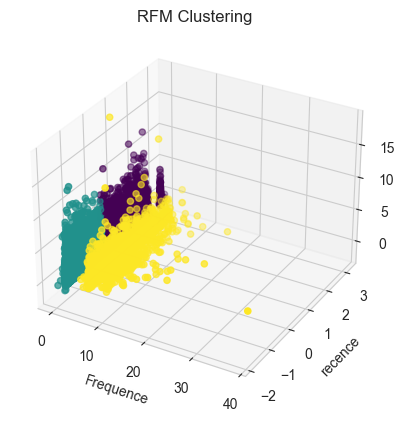

In [28]:
# Visualisation des résultats en 3D
fig=plt.figure()
ax=fig.add_subplot(111,projection='3d')
ax.scatter(data_rfm_norm['Frequence'],data_rfm_norm['recence'],data_rfm_norm['montant'],c=data_rfm_norm['cluster'],cmap='viridis')
ax.set_xlabel('Frequence')
ax.set_ylabel('recence')
ax.set_zlabel('montant')
ax.set_title('RFM Clustering')
plt.show()

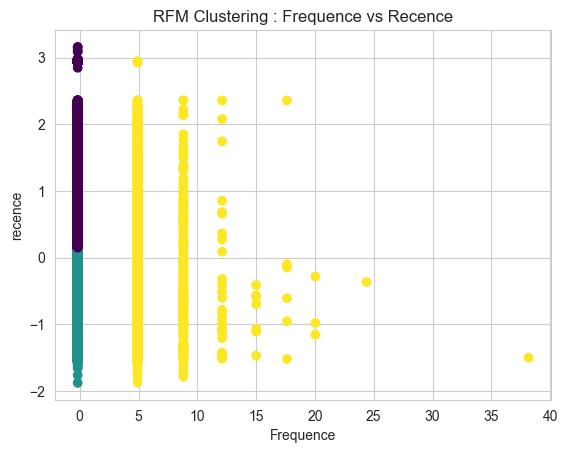

In [29]:
# Visualisation des résultats en 2D
plt.scatter(data_rfm_norm['Frequence'],data_rfm_norm['recence'],c=data_rfm_norm['cluster'],cmap='viridis')
plt.xlabel('Frequence')
plt.ylabel('recence')
plt.title('RFM Clustering : Frequence vs Recence')
plt.show()

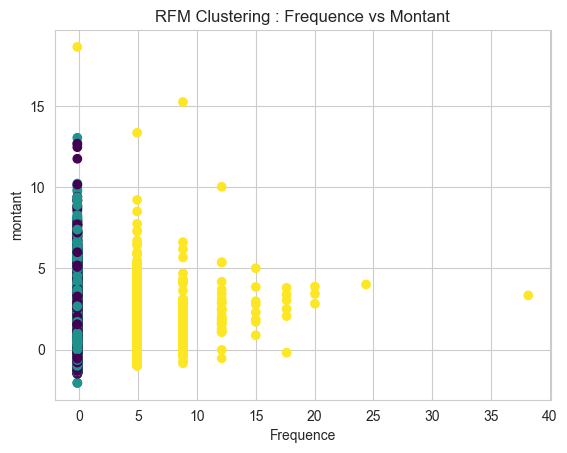

In [30]:
# Visualisation des résultats en 2D
plt.scatter(data_rfm_norm['Frequence'],data_rfm_norm['montant'],c=data_rfm_norm['cluster'],cmap='viridis')
plt.xlabel('Frequence')
plt.ylabel('montant')
plt.title('RFM Clustering : Frequence vs Montant')
plt.show()

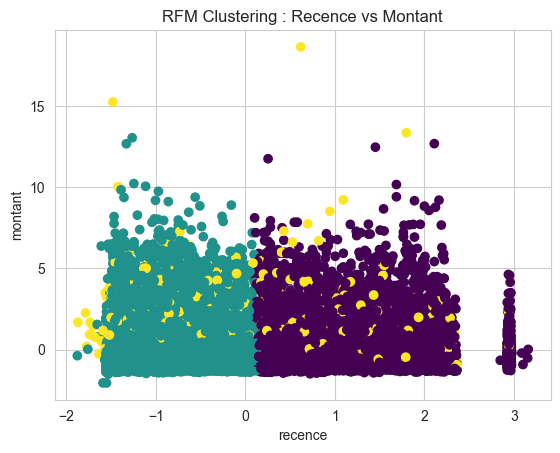

In [31]:
# Visualisation des résultats en 2D
plt.scatter(data_rfm_norm['recence'],data_rfm_norm['montant'],c=data_rfm_norm['cluster'],cmap='viridis')
plt.xlabel('recence')
plt.ylabel('montant')
plt.title('RFM Clustering : Recence vs Montant')
plt.show()

Traçons les graphiques radars :

In [32]:
data_fe_cluster.drop('customer_unique_id', axis=1, inplace=True)
data_fe_cluster

,AVG(estimated_delivery_delay),AVG(true_delivery_delay),AVG(late_delivery),SUM(price),SUM(freight_value),AVG(payment_payment_installments),AVG(review_score_moy),Frequence,recence,montant,cluster
0,11.0,6.0,-5.0,129.90,12.00,8.0,5.0,1,2314.0,141.90,1
1,8.0,3.0,-5.0,18.90,8.29,1.0,4.0,1,2317.0,27.19,1
2,28.0,26.0,-2.0,69.00,17.22,8.0,3.0,1,2740.0,86.22,0
3,32.0,20.0,-12.0,25.99,17.63,4.0,4.0,1,2524.0,43.62,0
4,21.0,13.0,-8.0,180.00,16.89,6.0,5.0,1,2491.0,196.89,0
...,...,...,...,...,...,...,...,...,...,...,...
96091,55.0,28.0,-27.0,680.00,239.14,10.0,5.0,1,2650.0,2067.42,0
96092,33.0,30.0,-3.0,64.89,19.69,1.0,4.0,1,2465.0,84.58,0
96093,45.0,15.0,-30.0,89.90,22.56,1.0,5.0,1,2771.0,112.46,0
96094,26.0,12.0,-14.0,115.00,18.69,5.0,5.0,1,2322.0,133.69,1


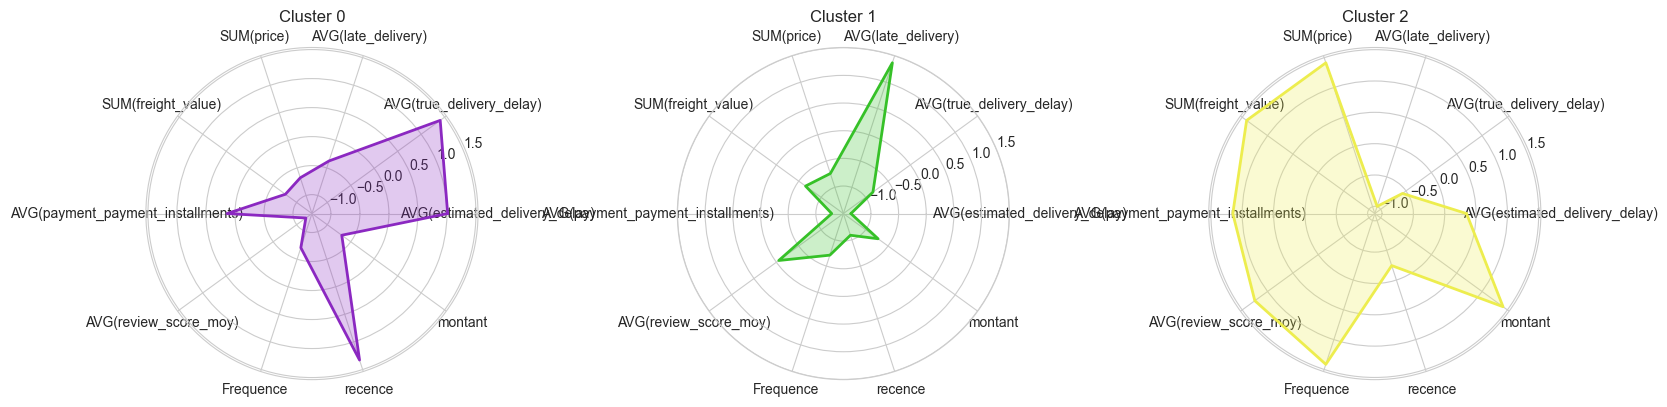

In [33]:
# Liste de toutes les variables que vous souhaitez inclure dans le radar plot
features = data_fe_cluster.columns[:-1]

# Calcul des moyennes des nouvelles variables pour chaque cluster
# Assurez-vous que les nouvelles variables sont présentes dans data_rfm_norm
cluster_means = data_fe_cluster.groupby('cluster')[features].mean()

# Normalisation des moyennes des clusters
scaler=StandardScaler()
cluster_means_norm = pd.DataFrame(scaler.fit_transform(cluster_means),columns=features)

# Calcul des angles pour le graphique en toile d'araignée
angles = [n / float(len(features)) * 2 * np.pi for n in range(len(features))]
angles += angles[:1]

# Création de la figure et des sous-graphiques
fig, axes = plt.subplots(1,3,figsize=(18, 8), subplot_kw={'polar': True})
cluster_colors = ['#8b28c1','#36c128','#EDED4E']
plt.subplots_adjust(wspace=0.6)

# Tracer chaque cluster
for i in range(3):
  ax=axes[i]
  values = cluster_means_norm.iloc[i].tolist()
  values += values[:1]
  ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Cluster {i}", color=cluster_colors[i])
  ax.fill(angles, values, alpha=0.25, facecolor=cluster_colors[i])

# étiquettes des axes et légende
  ax.set_xticks(angles[:-1])
  ax.set_xticklabels(features)
  ax.set_title(f"Cluster {i}")

plt.show()


Le clustering RFM avec l'algorithme du kmeans définit 3 clusters :
- les clients qui ont commandés une seule fois moins récemment (violet) avec des montants moyens et des délais de livraisons longs mais pas forcément de retard. Ces long délais de livraison expliqueraient les notes plutôt faibles mises par ces clients.Cela correspond plutôt à des clients "perdus" pour l'entreprise.
- les clients qui ont commandés une seule fois assez récemment (vert) avec des montants moyens et des retards de livraisons importants, ce qui expliquerai les notes moyennes mises par ces clients. Cela correspond plutôt à des clients "nouveaux mais pas forcément convaincus" pour l'entreprise.
- les clients qui ont commandés plus d'une fois (jaune) et qui ont par conséquent des montants plus élevés et de nombreux paiements étalés. Ils ont également des avances de livraisons importantes ce qui peut expliquer les notes élevées qu'ils ont mises. Ce sont plutôt des clients "réguliers" pour l'entreprise.

In [34]:
# Calcul de la répartition des clusters
data_cluster =data_rfm_norm.groupby('cluster', dropna=False)['recence'].count()
print(data_cluster)

cluster
0    39721
1    53377
2     2998
Name: recence, dtype: int64


Text(0.5, 1.0, 'Proportion des clusters dans la population')

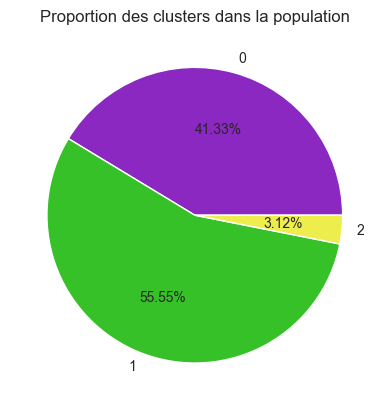

In [35]:

labels = ['0','1','2']
colors = ['#8b28c1','#36c128','#EDED4E']
sns.set_style("darkgrid")
# Affichage d'un diagramme circulaire pour visualiser la proportion des nutriscores dans notre base de données
plt.pie(x=data_cluster, labels=labels, colors=colors,autopct='%.2f%%')
plt.title("Proportion des clusters dans la population")

Très peu de clients ont commandés plus d'une fois (jaune).

Il y a plus de la moitié des clients qui ont commandés une fois assez récemment(vert) par rapport à ceux qui ont commandés plus anciennement (violet).

In [36]:
# Calcul de la somme des montants en fonction des clusters
data_cluster_ca =data_fe_cluster.groupby('cluster', dropna=False)['montant'].sum()
print(data_cluster_ca)

cluster
0    6474966.23
1    8576219.10
2     957686.79
Name: montant, dtype: float64


Text(0.5, 1.0, 'Proportion des clusters en fonction du CA')

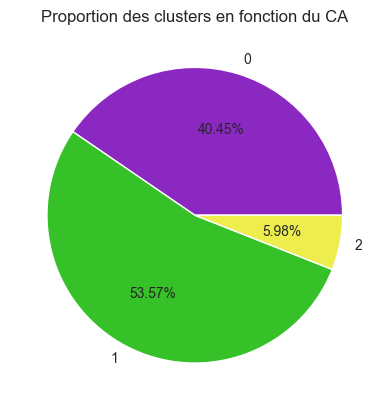

In [37]:
labels = ['0','1','2']
colors = ['#8b28c1','#36c128','#EDED4E']
sns.set_style("darkgrid")
# Affichage d'un diagramme circulaire pour visualiser la proportion des nutriscores dans notre base de données
plt.pie(x=data_cluster_ca, labels=labels, colors=colors,autopct='%.2f%%')
plt.title("Proportion des clusters en fonction du CA")

Les clients qui ont commandés plus d'une fois (jaune) représente tout de même 6% du CA.

Les clients qui ont commandés une fois assez récemment(vert) sont plus nombreux que ceux qui ont commandés plus anciennement (violet) et représente donc plus en terme de CA ( 54% vs 40%).



Cherchons maintenant le nombre optimal de clusters.

#### Optimisation du nombre de clusters avec la méthode du coude

Pour cette méthode, on trace la somme des carrés des distances intra-cluster (ou SSE) en foncion du nombre de cluster. Le nombre de cluster optimal est le point où la courbe commence à se stabiliser.

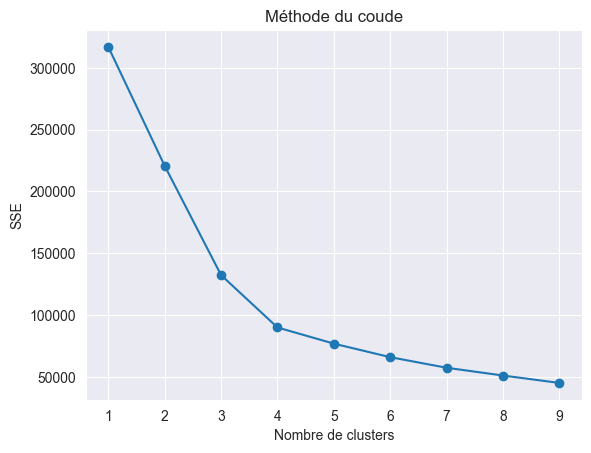

In [38]:
SSE=[]
for i in range(1,10):
    kmeans_sse=KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=300,random_state=42)
    kmeans_sse.fit(data_rfm_norm)
    SSE.append(kmeans_sse.inertia_)

# Visualisation de la courbe de la méthode du coude
plt.plot(range(1,10),SSE,marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('SSE')
plt.title('Méthode du coude')
plt.show()

#### Optimisation du nombre de clusters avec la méthode de la silhouette

Cette méthode mesure si chaque point est bien regroupé au sein de son propre cluster par rapport aux autres clusters. Il varie de -1 (mal regroupés) à 1 (bien regroupés).

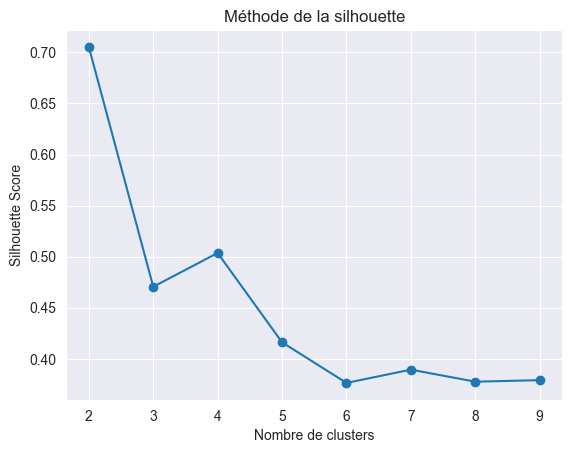

In [39]:
sil=[]
for i in range(2,10):
    kmeans_sil=KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=300,random_state=42)
    kmeans_sil.fit(data_rfm_norm)
    labels = kmeans_sil.labels_
    sil.append(silhouette_score(data_rfm_norm,labels))

plt.plot(range(2,10),sil,marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.title('Méthode de la silhouette')
plt.show()

#### Optimisation du nombre de clusters avec la méthode de Davies-Bouldin

Plus l'indice est bas, meilleure est la séparation entre les clusters.

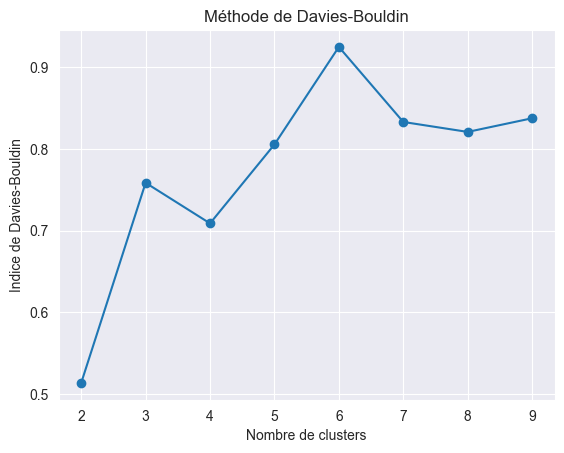

In [40]:
db=[]
for i in range(2,10):
    kmeans_db=KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=300,random_state=42)
    clusters=kmeans_db.fit_predict(data_rfm_norm)
    db.append(davies_bouldin_score(data_rfm_norm,clusters))

plt.plot(range(2,10),db,marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Indice de Davies-Bouldin')
plt.title('Méthode de Davies-Bouldin')
plt.show()

Pour n_clusters = 2 Le score de silhouette moyen est de: 0.7053544473177509
Pour n_clusters = 3 Le score de silhouette moyen est de: 0.4705802773294923
Pour n_clusters = 4 Le score de silhouette moyen est de: 0.5036242789755717


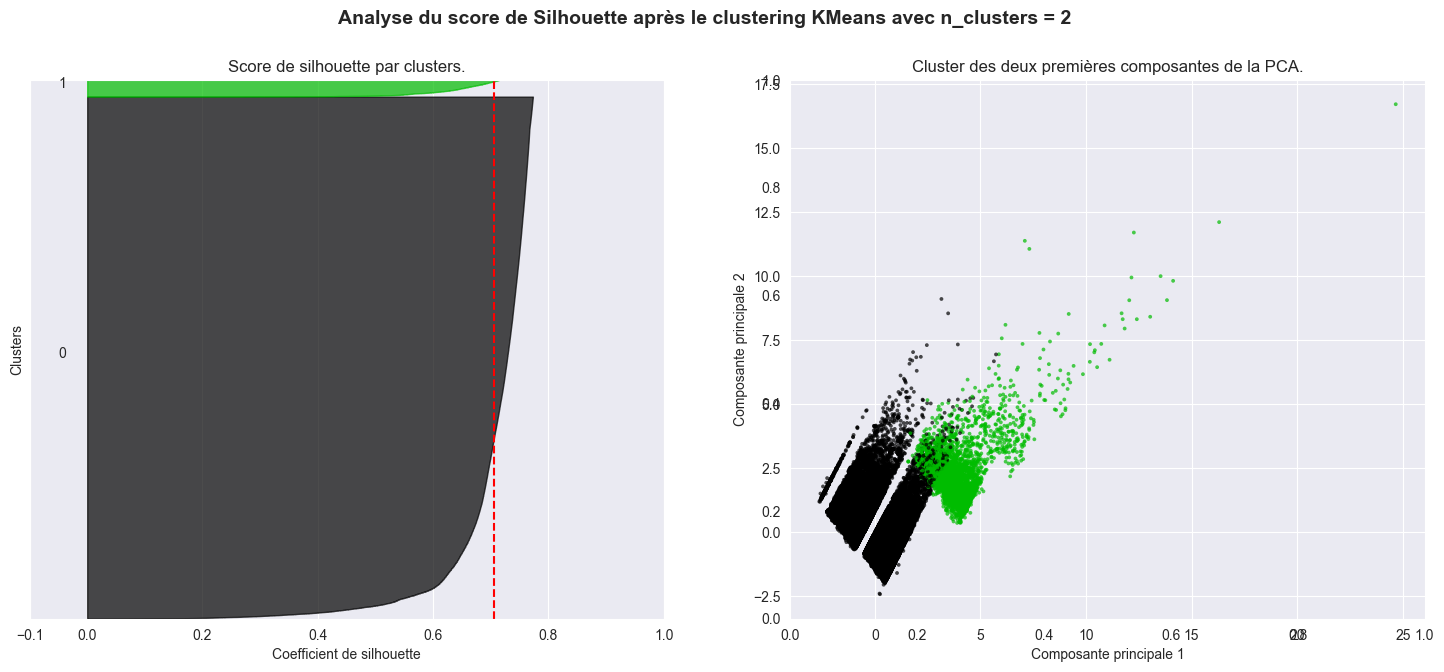

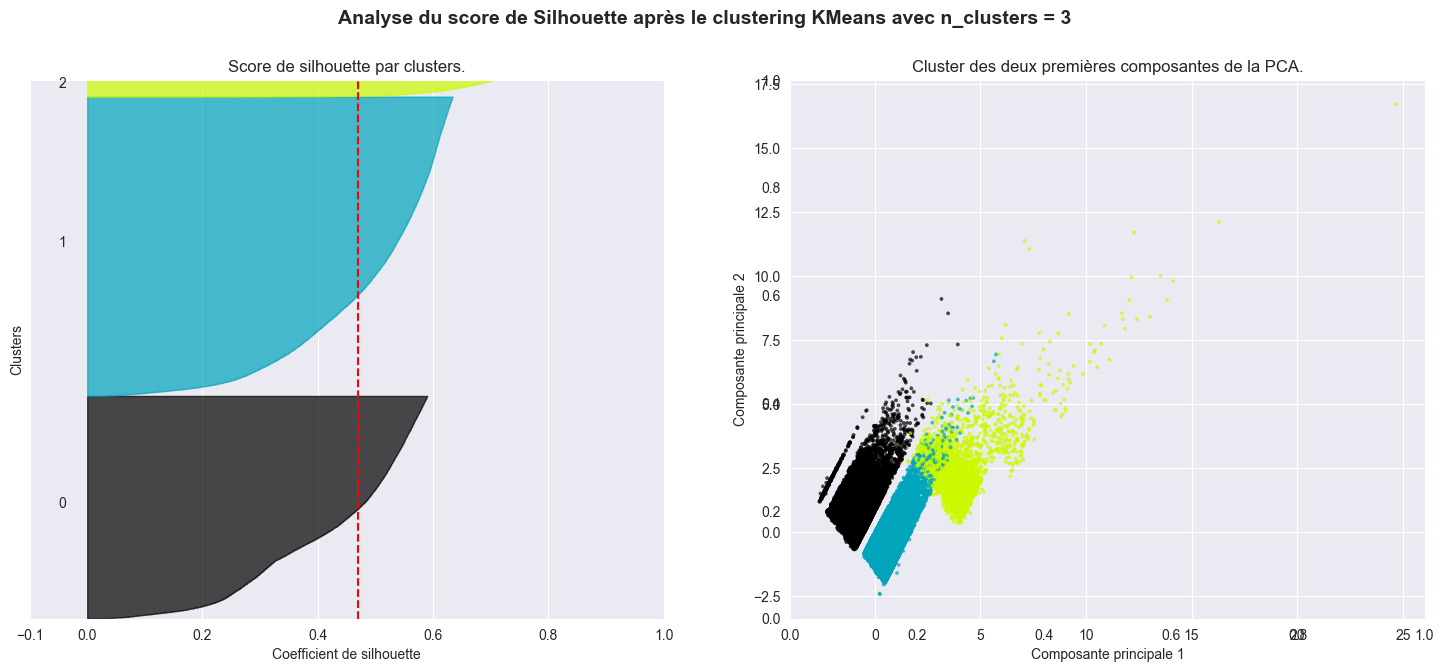

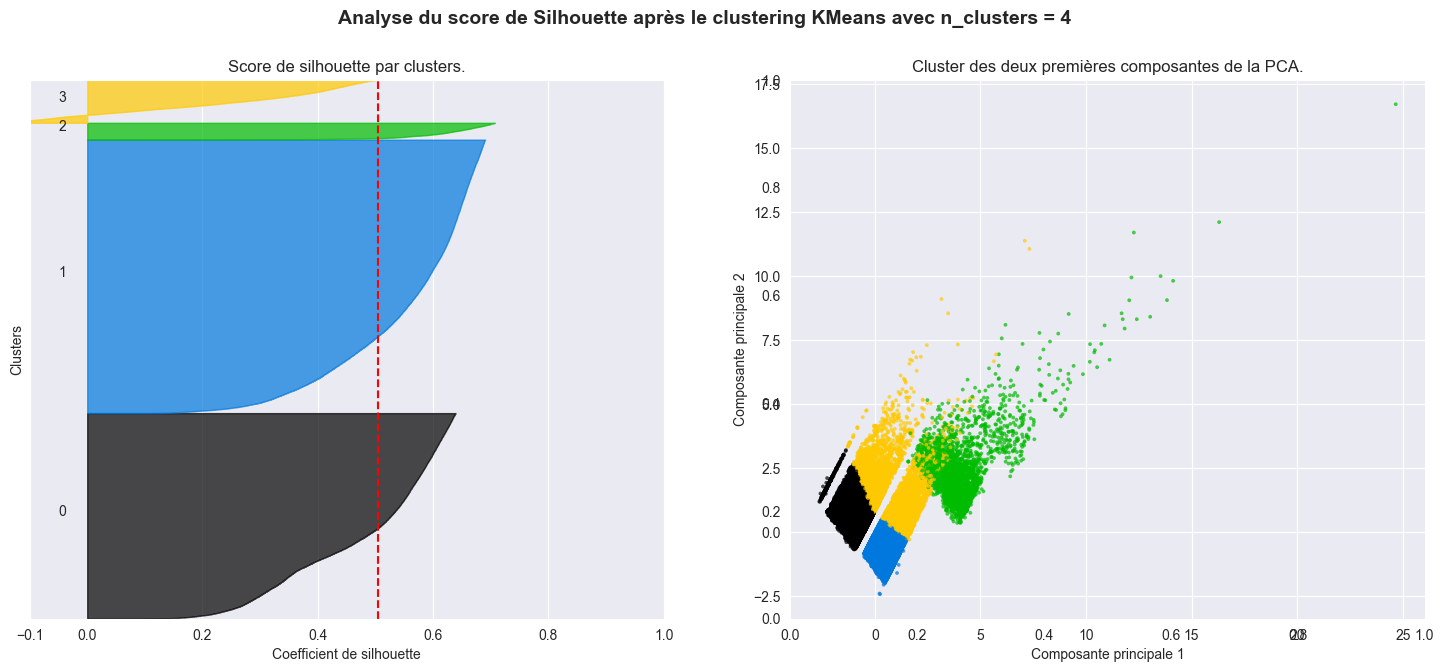

In [41]:
range_n_clusters = [2, 3, 4]


for n_clusters in range_n_clusters:
    # Creation des graphiques 1 lignes, 3 colonnes
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # Premier graphique : score de silhouette par cluster
    # Le coefficient de silhouette peut aller de -1, 1 mais on le fera de [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    #  (n_clusters+1)*10 pour insérer un espace pour démarquer les clusters
    ax1.set_ylim([0, len(data_rfm_norm) + (n_clusters + 1) * 10])

    # Clustering
    clusterer = KMeans(n_clusters=n_clusters,init='k-means++',n_init=10,max_iter=300,random_state=42)
    cluster_labels = clusterer.fit_predict(data_rfm_norm)

    # Calcul des scores de silhouette
    silhouette_avg = silhouette_score(data_rfm_norm, cluster_labels)
    print(
        "Pour n_clusters =",
        n_clusters,
        "Le score de silhouette moyen est de:",
        silhouette_avg,
    )

    # Calcul du score de silhouette pour chaque échantillon
    sample_silhouette_values = silhouette_samples(data_rfm_norm, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Titre du graphiques et étiquettes
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Score de silhouette par clusters.")
    ax1.set_xlabel("Coefficient de silhouette")
    ax1.set_ylabel("Clusters")

    # Ligne verticale pour le score de silhouette moyen
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Deuxième graphique : clusters formés selon les deux premières variables "fréquence" et "recence"

    # PCA
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data_rfm_norm)

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.scatter(data_pca[:, 0],data_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    ax2.set_title("Cluster des deux premières composantes de la PCA.")
    ax2.set_xlabel("Composante principale 1")
    ax2.set_ylabel("Composante principale 2")

    plt.suptitle(
        "Analyse du score de Silhouette après le clustering KMeans avec n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Le nombre de cluster optimal  est de 3 puisque les graphiques de score de silhouette pour 2 ou 4 clusters montrent qu'à chaque fois un cluster n'atteint pas (ou à peine)le score de silhouette moyen. De plus, dans les visualisations après PCA, les clusters paraissent plus facilement séparables qu'avec 2 ou 4 clusters. Le clustering KMeans à 3 clusters a été précédemment testé.

#### Evaluation

In [42]:
# on veut des distances intraclusters (c'est l'homogénéité) faibles et des distances interclusters (la séparation) grandes.
# cela correspond à un silhouette score égal à 1, un score de Davies Bouldin bas et un score Calinsky Harabasz élevé.
sil_score=silhouette_score(data_rfm_norm,kmeans.labels_)
db_score=davies_bouldin_score(data_rfm_norm,kmeans.labels_)
ch_score=calinski_harabasz_score(data_rfm_norm,kmeans.labels_)

print(f"Le score de silhouette est de : {sil_score}")
print(f"Le score de Davies-Bouldin est de : {db_score}")
print(f"Le score de Calinsky-Harabasz est de : {ch_score}")

Le score de silhouette est de : 0.4705802773294923
Le score de Davies-Bouldin est de : 0.7586642282893098
Le score de Calinsky-Harabasz est de : 67037.44909948744


Le score de silhouette est moyen et ces scores vont nous servir de base pour comparer.

Testons la stabilité du clustering :

In [43]:
n_runs=10
labels_list=[]
labels_list.append(kmeans.labels_)
# Différente initialisation du k-means
for i in range(n_runs):
  kmeans_ari=KMeans(init='k-means++',n_clusters=3,n_init=10,max_iter=300, random_state=42+i*10)
  kmeans_ari.fit(data_rfm_norm)
  labels_list.append(kmeans_ari.labels_)
# Calcul de l'ARI entre les paires de labels
ari_score=[]
for i in range(n_runs+1):
    for j in range(i+1, n_runs+1):
      ari = adjusted_rand_score(labels_list[i], labels_list[j])
      ari_score.append(ari)
print(f"Le score moyen de l'ARI est de :", np.mean(ari_score))
print(f"L'écart-type de l'ARI est de :", np.std(ari_score))


Le score moyen de l'ARI est de : 1.0
L'écart-type de l'ARI est de : 0.0


In [44]:
# n_runs=10
# labels_list=[]
# labels_list.append(kmeans.labels_)
# # Différente initialisation du k-means
# for i in range(n_runs):
#   noise=np.random.normal(0,0.1,data_rfm_norm.shape)
#   noisy_data=data_rfm_norm+noise
#   kmeans_ari=KMeans(init='k-means++',n_clusters=3,n_init=10,max_iter=300, random_state=42+i*10)
#   kmeans_ari.fit(noisy_data)
#   labels_list.append(kmeans_ari.labels_)
# # Calcul de l'ARI entre les paires de labels
# ari_score=[]
# for i in range(n_runs+1):
#     for j in range(i+1, n_runs+1):
#       ari = adjusted_rand_score(labels_list[i], labels_list[j])
#       ari_score.append(ari)
# print(f"Le score moyen de l'ARI est de :", np.mean(ari_score))
# print(f"L'écart-type de l'ARI est de :", np.std(ari_score))


#  L'ajout de bruit ne modifie que peu la stabilité de l'algorithme.

Le score ARI est compris entre 0 (aléatoire) et 1 (parfaite concordance). Ici, nous avons donc une stabilité parfaite de notre clustering.

#### Conclusion

Notre clustering est stable mais les variables choisies peuvent être optimisées puisque l'un des clusters (jaune) ne représente que 3% de la population.

La fréquence qui est caractéristique de ce cluster jaune n'est donc pas forcément une variable pertinente.

De même, la récence n'étant basé que sur une date (celle du dernier achat), cette variable risque de ne pas rendre l'algorithme de clustering très stable dans le temps.

Retirons-les et ajoutons la satisfaction client, l'avance/retard de livraison et l'échelonnage des paiements.

## Clustering Montant-Satisfaction-Retard de livraison-Echelonnage de paiement :



In [45]:
sql_query_string = """
SELECT customer_unique_id,SUM(payment_total) AS montant,AVG(review_score_moy) AS satisfaction, AVG(late_delivery) AS retard_livraison, AVG(payment_payment_installments) AS echelonnage_paiement
FROM data_fe_CL
GROUP BY 1
ORDER BY 1
"""

df_temp=sql_query_to_pd(sql_query_string, db_name='/tutorial-env/OCR/Projet5/olist.db')

# Création du dataframe MSLE :
data_msle = pd.DataFrame(df_temp)
data_msle.describe()

,montant,satisfaction,retard_livraison,echelonnage_paiement
count,96095.000000,95380.000000,93356.000000,96095.000000
mean,166.594226,4.084811,-11.849300,2.902892
std,231.428912,1.341711,10.140626,2.687117
min,0.000000,1.000000,-147.000000,0.000000
25%,63.120000,4.000000,-17.000000,1.000000
50%,108.000000,5.000000,-12.000000,2.000000
75%,183.530000,5.000000,-7.000000,4.000000
max,13664.080000,5.000000,188.000000,24.000000


### Analyse de la variable satisfaction :

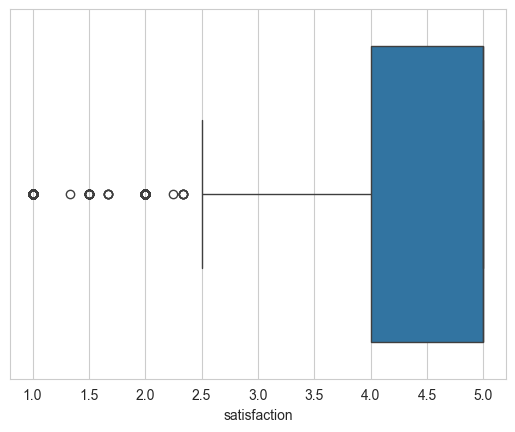

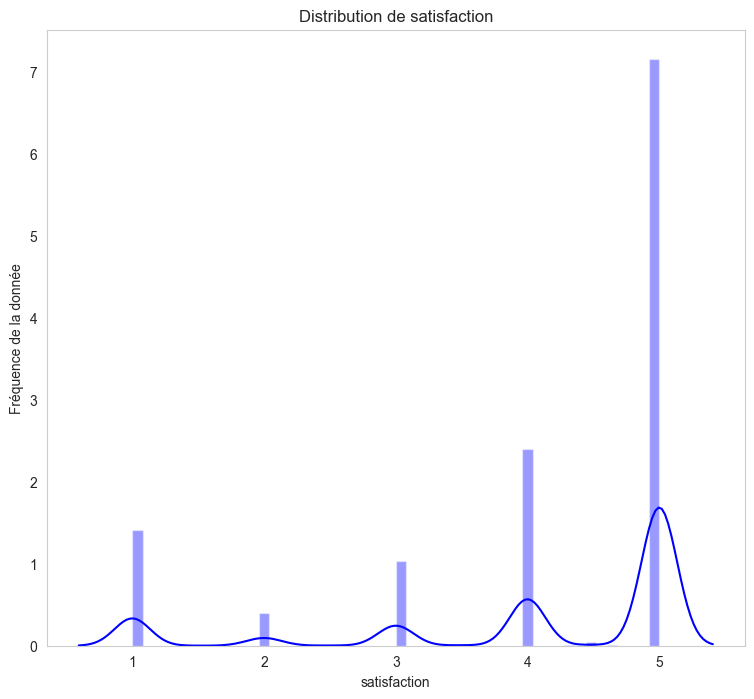

,Caractéristiques,Valeurs
0,count,95380.000000
1,mean,4.084811
2,std,1.341711
3,min,1.000000
4,25%,4.000000
5,50%,5.000000
6,75%,5.000000
7,max,5.000000


In [46]:
describe_data_quant(data_msle, 'satisfaction')

La variable "satisfaction" a une variance qui pourra potentiellement être utile pour le clustering.

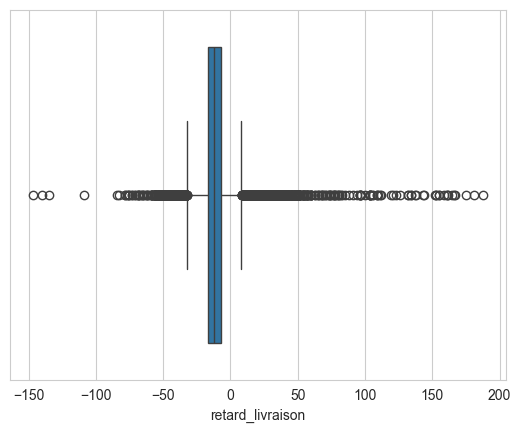

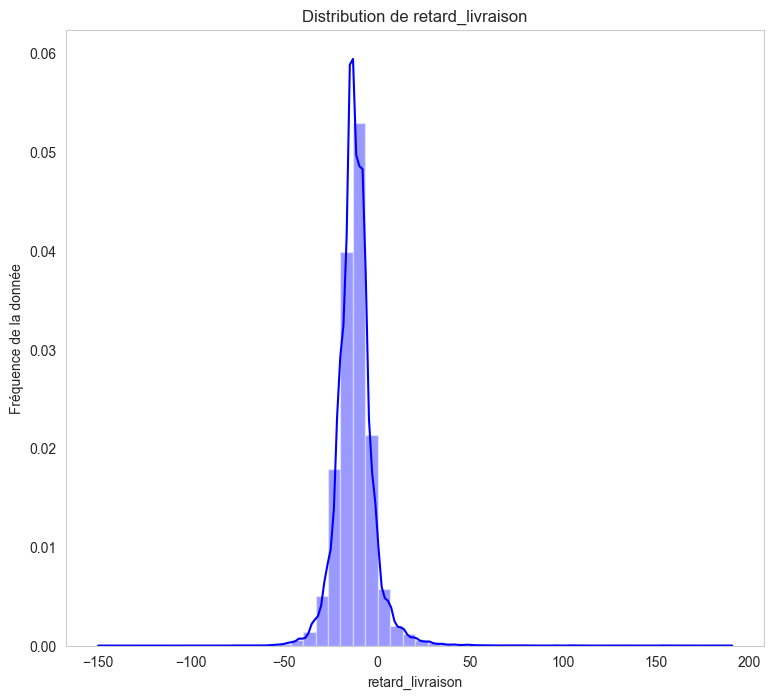

,Caractéristiques,Valeurs
0,count,93356.000000
1,mean,-11.849300
2,std,10.140626
3,min,-147.000000
4,25%,-17.000000
5,50%,-12.000000
6,75%,-7.000000
7,max,188.000000


In [47]:
describe_data_quant(data_msle, 'retard_livraison')

La variable "retard_livraison" a une variance qui pourra potentiellement être utile pour le clustering.

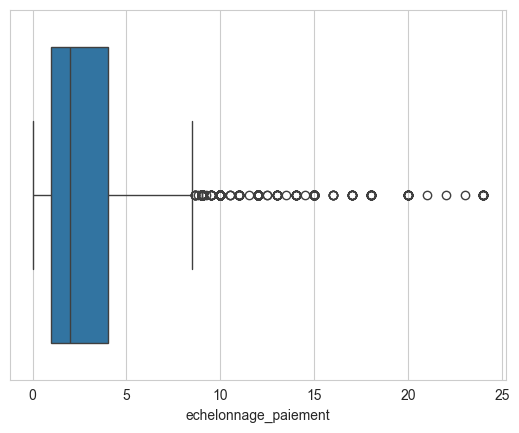

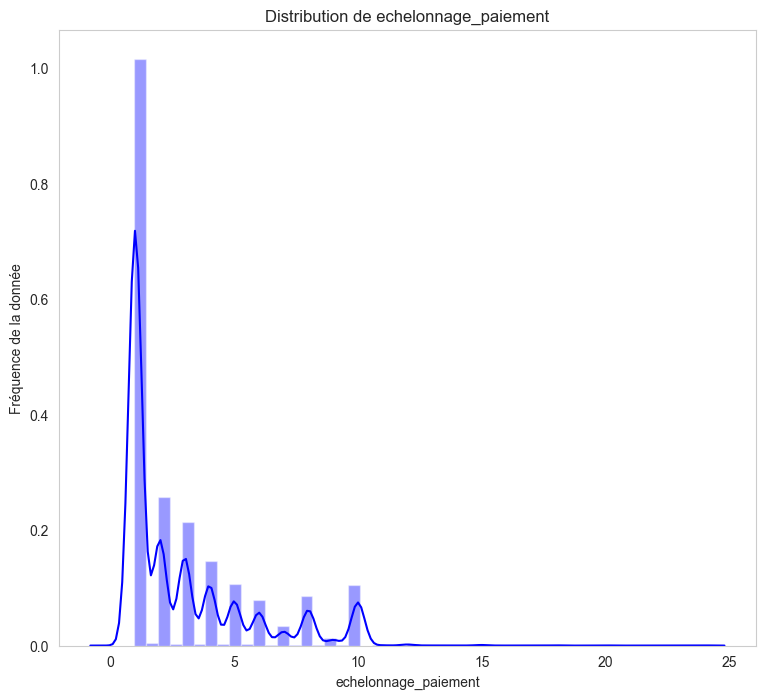

,Caractéristiques,Valeurs
0,count,96095.000000
1,mean,2.902892
2,std,2.687117
3,min,0.000000
4,25%,1.000000
5,50%,2.000000
6,75%,4.000000
7,max,24.000000


In [48]:
describe_data_quant(data_msle, 'echelonnage_paiement')

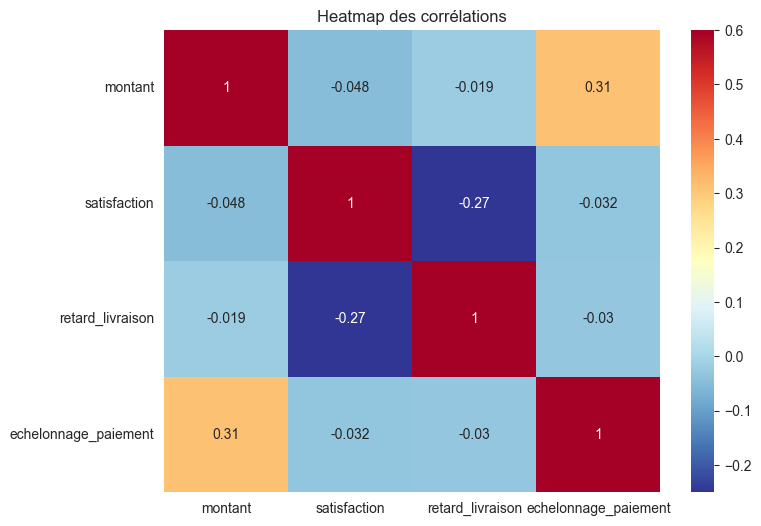

In [49]:
plt.figure(figsize = (8, 6))
data_corr = data_msle.select_dtypes(include=['float', 'int64'])
# Heatmap des correlations
sns.heatmap(data_corr.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Heatmap des corrélations');

Il n'y a pas de corrélations entre ces quatres variables, ce qui est important pour le clustering.

In [50]:
#  Appel de la fonction affichant le pourcentage de valeur manquantes par variable
data_msle_vm=show_miss_val(data_msle)
data_msle_vm.head(26)

Notre dataframe a 5 variables.
 Il y a 4 variables contenant des valeurs manquantes.


,variable,miss_val
1,montant,0.000010
4,echelonnage_paiement,0.000010
2,satisfaction,0.007451
3,retard_livraison,0.028513


Il y a très peu de valeurs manquantes mais nous allons quand même imputer par la médiane pour que l'ensemble du jeu de données puisse être utilisé dans le clustering.

In [51]:
# Créer une instance de SimpleImputer
imputer = SimpleImputer(strategy='median')
# Remodeler la colonne en un tableau 2D
data_temp = data_msle['montant'].values.reshape(-1, 1)
data_temp_ = data_msle['satisfaction'].values.reshape(-1, 1)
data_temp__ = data_msle['retard_livraison'].values.reshape(-1, 1)
data_temp___ = data_msle['echelonnage_paiement'].values.reshape(-1, 1)
data_msle['montant'] = imputer.fit_transform(data_temp)
data_msle['satisfaction'] = imputer.fit_transform(data_temp_)
data_msle['retard_livraison'] = imputer.fit_transform(data_temp__)
data_msle['echelonnage_paiement'] = imputer.fit_transform(data_temp___)

data_msle_vm=show_miss_val(data_msle)
data_msle_vm.head(26)

Notre dataframe a 5 variables.
 Il y a 0 variables contenant des valeurs manquantes.


,variable,miss_val


Nous avons imputé toutes les valeurs manquantes par la médiane, enlevons la
colonne avec les identifiants clients et normalisons maintenant notre dataframe :

In [52]:
# Création d'un dataframe après transformation en racine carré de 'montant'
data_msle_sqrt = pd.DataFrame()
data_msle_sqrt['montant']= np.sqrt(data_msle['montant'])
data_msle_sqrt['satisfaction']= data_msle['satisfaction']
data_msle_sqrt['retard_livraison']= data_msle['retard_livraison']
data_msle_sqrt['echelonnage_paiement']= data_msle['echelonnage_paiement']

In [53]:
# Créer une instance de Standardscaler
scaler = StandardScaler()

# Normalisation des données
data_msle_norm = pd.DataFrame(scaler.fit_transform(data_msle_sqrt),columns=data_msle_sqrt.columns)

data_msle_norm.describe(include="all")

,montant,satisfaction,retard_livraison,echelonnage_paiement
count,9.609600e+04,9.609600e+04,9.609600e+04,9.609600e+04
mean,1.311712e-16,6.239135e-16,-1.030737e-16,4.436456e-19
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-2.051783e+00,-2.308890e+00,-1.352142e+01,-1.080307e+00
25%,-6.468183e-01,-6.843084e-02,-5.148984e-01,-7.081574e-01
50%,-2.140019e-01,6.783890e-01,-1.464765e-02,-3.360076e-01
75%,3.439336e-01,6.783890e-01,4.856031e-01,4.082918e-01
max,1.861972e+01,6.783890e-01,1.999538e+01,7.851286e+00


### K-Means

#### Recherche du nombre de clusters avec la méthode du coude

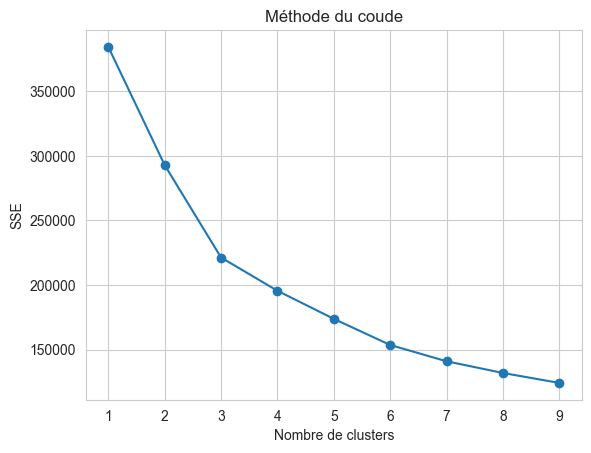

In [54]:
SSE=[]
for i in range(1,10):
    kmeans_sse=KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=300,random_state=42)
    kmeans_sse.fit(data_msle_norm)
    SSE.append(kmeans_sse.inertia_)

# Visualisation de la courbe de la méthode du coude
plt.plot(range(1,10),SSE,marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('SSE')
plt.title('Méthode du coude')
plt.show()

#### Recherche du nombre de clusters avec la méthode de la silhouette



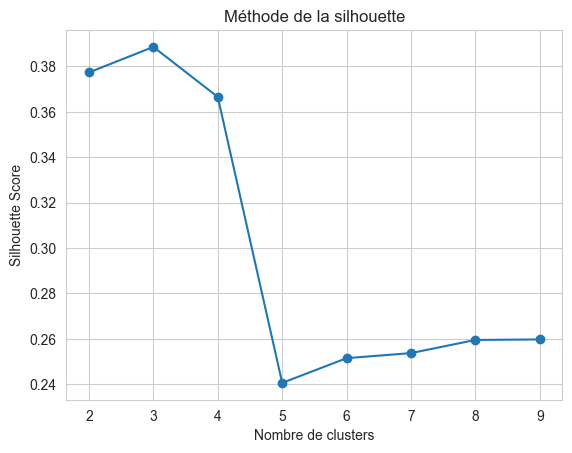

In [55]:
sil=[]
for i in range(2,10):
    kmeans_sil=KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=300,random_state=42)
    kmeans_sil.fit(data_msle_norm)
    labels = kmeans_sil.labels_
    sil.append(silhouette_score(data_msle_norm,labels))

plt.plot(range(2,10),sil,marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.title('Méthode de la silhouette')
plt.show()

#### Optimisation du nombre de clusters avec la méthode de Davies-Bouldin

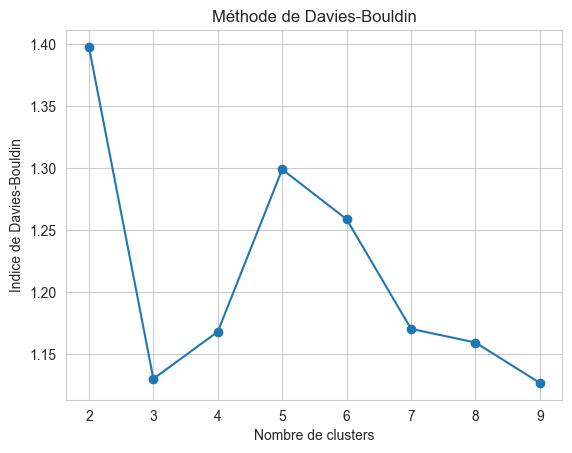

In [56]:
db=[]
for i in range(2,10):
    kmeans_db=KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=300,random_state=42)
    clusters=kmeans_db.fit_predict(data_msle_norm)
    db.append(davies_bouldin_score(data_msle_norm,clusters))

plt.plot(range(2,10),db,marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Indice de Davies-Bouldin')
plt.title('Méthode de Davies-Bouldin')
plt.show()

Pour n_clusters = 2 Le score de silhouette moyen est de: 0.3773711151757485
Pour n_clusters = 3 Le score de silhouette moyen est de: 0.3886106169781589
Pour n_clusters = 4 Le score de silhouette moyen est de: 0.3665841043842879


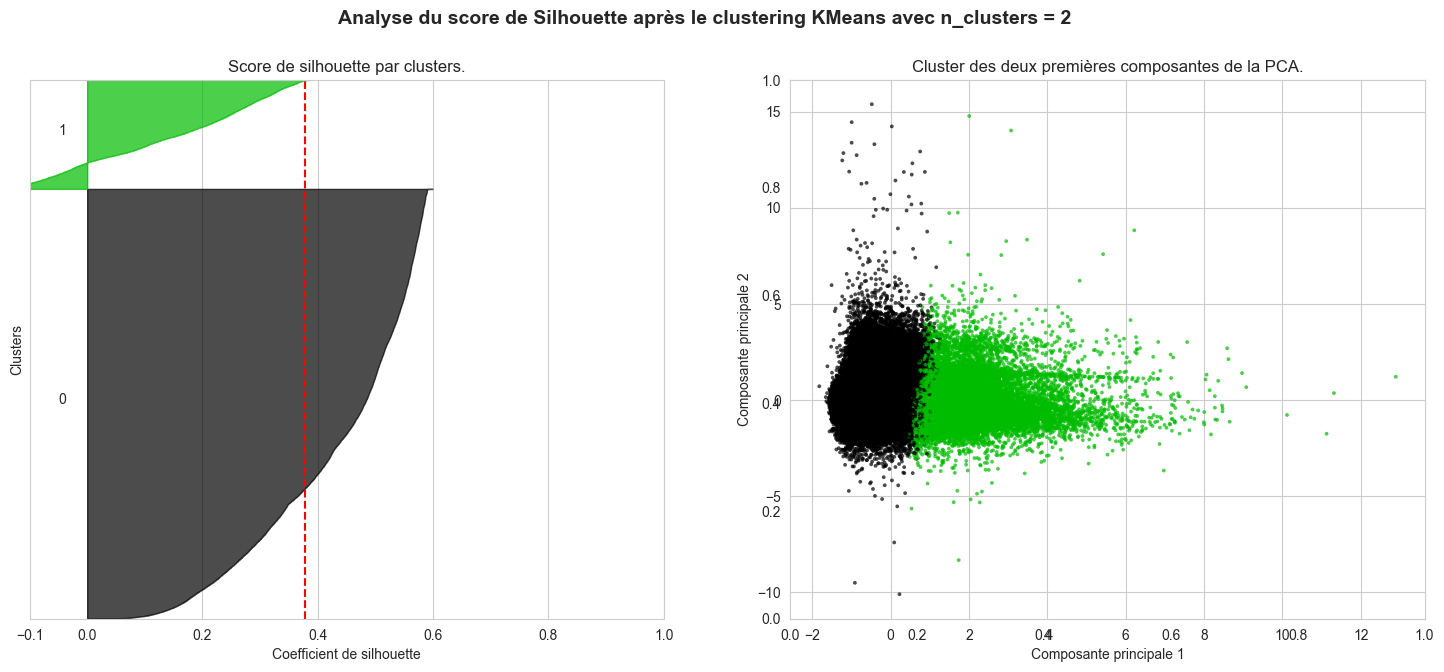

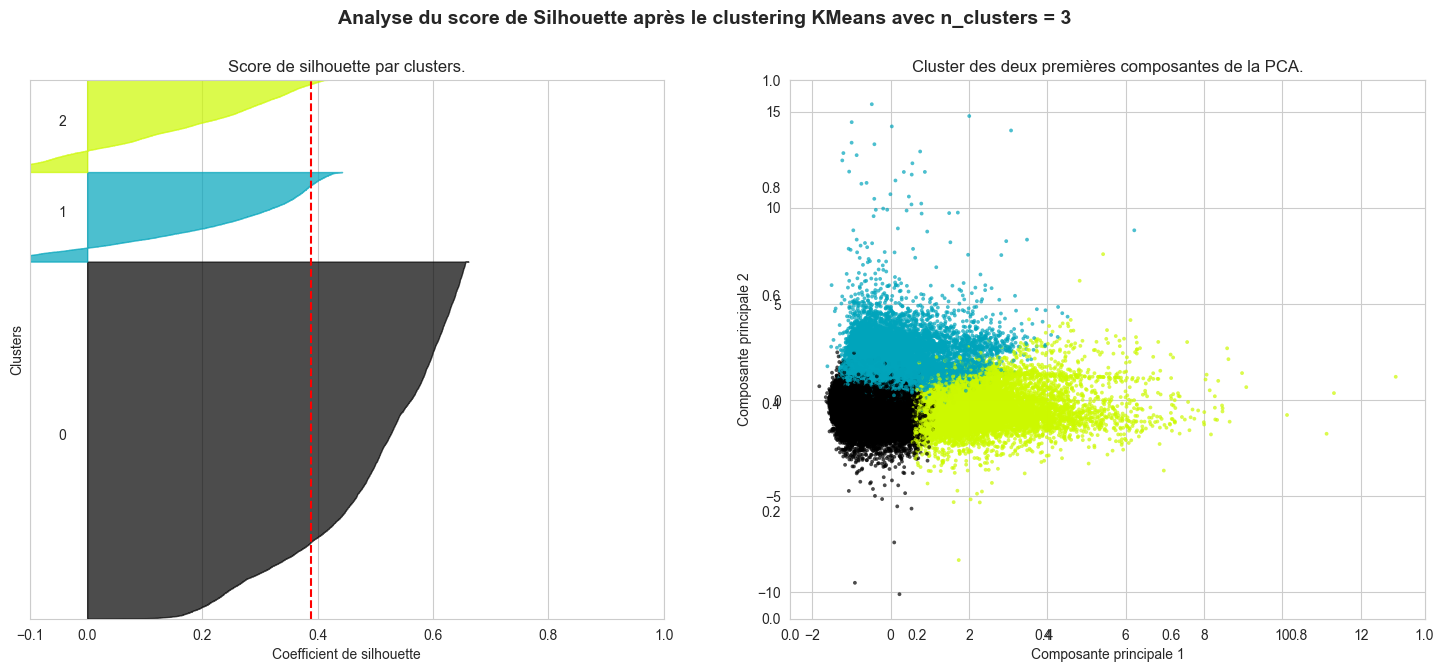

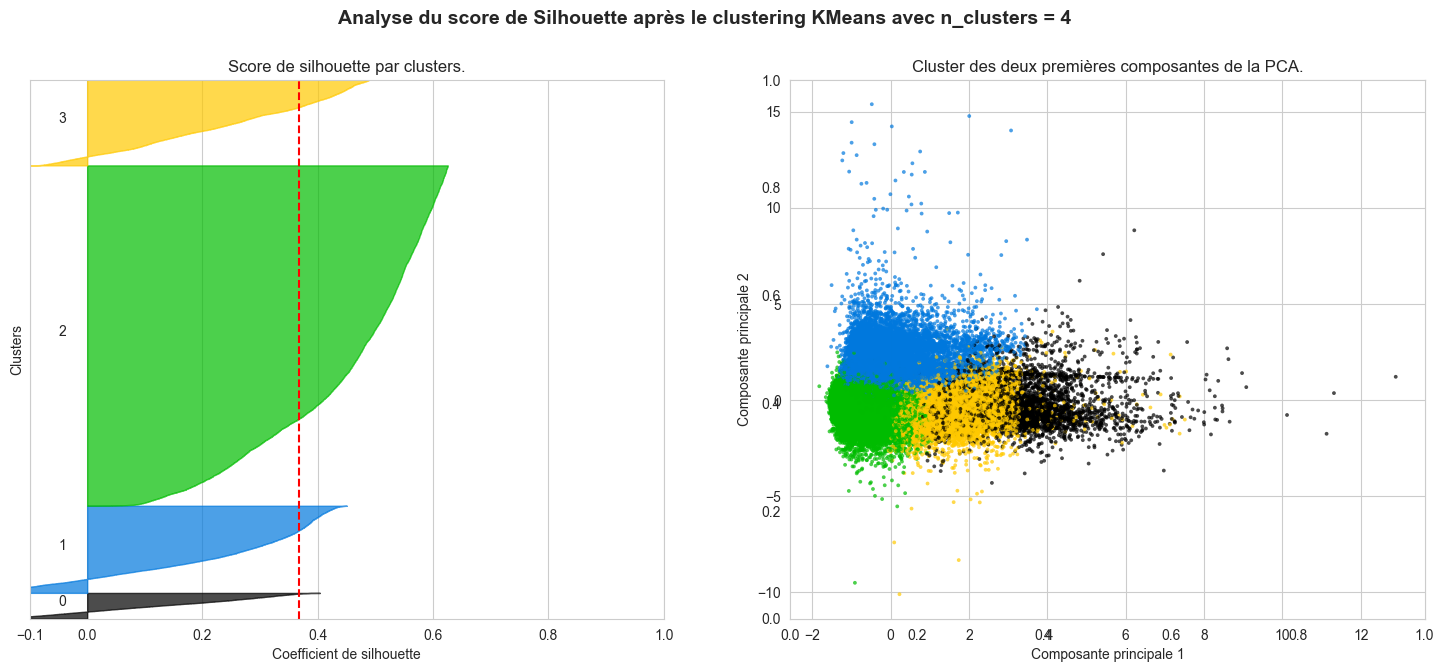

In [57]:
range_n_clusters = [2,3,4]

for n_clusters in range_n_clusters:
    # Creation des graphiques 1 lignes, 3 colonnes
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # Premier graphique : score de silhouette par cluster
    # Le coefficient de silhouette peut aller de -1, 1 mais on le fera de [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    #  (n_clusters+1)*10 pour insérer un espace pour démarquer les clusters
    ax1.set_ylim([0, len(data_msle_norm) + (n_clusters + 1) * 10])

    # Clustering
    clusterer = KMeans(n_clusters=n_clusters,init='k-means++',n_init=10,max_iter=300,random_state=42)
    cluster_labels = clusterer.fit_predict(data_msle_norm)

    # Calcul des scores de silhouette
    silhouette_avg = silhouette_score(data_msle_norm, cluster_labels)
    print(
        "Pour n_clusters =",
        n_clusters,
        "Le score de silhouette moyen est de:",
        silhouette_avg,
    )

    # Calcul du score de silhouette pour chaque échantillon
    sample_silhouette_values = silhouette_samples(data_msle_norm, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Titre du graphiques et étiquettes
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Score de silhouette par clusters.")
    ax1.set_xlabel("Coefficient de silhouette")
    ax1.set_ylabel("Clusters")

    # Ligne verticale pour le score de silhouette moyen
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Deuxième graphique : clusters formés selon les deux premières variables "fréquence" et "recence"

    # PCA
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data_msle_norm)

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.scatter(data_pca[:, 0],data_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    ax2.set_title("Cluster des deux premières composantes de la PCA.")
    ax2.set_xlabel("Composante principale 1")
    ax2.set_ylabel("Composante principale 2")

    plt.suptitle(
        "Analyse du score de Silhouette après le clustering KMeans avec n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Dans les 3 cas, nous avons des individus avec des scores de silhouettes négatifs donc nous n'aurons pas de clustering optimal. Il semble cependant que le clustering à 3 clusters permettra une meilleure séparation.

#### K-Means à 3 clusters

In [58]:
kmeans_3 = KMeans(init="random",n_clusters=3,n_init=10,max_iter=300,random_state=42)

kmeans_3.fit(data_msle_norm)

# Ajout des labels de cluster au dataframe
data_msle_norm['cluster'] = kmeans_3.labels_

In [59]:
data_msle_norm

,montant,satisfaction,retard_livraison,echelonnage_paiement,cluster
0,0.054773,0.678389,0.685703,1.896891,0
1,-1.129665,-0.068431,0.685703,-0.708157,2
2,-0.409735,-0.815251,0.985854,1.896891,0
3,-0.883832,-0.068431,-0.014648,0.408292,2
4,0.429600,0.678389,0.385553,1.152591,0
...,...,...,...,...,...
96091,5.988962,0.678389,-1.515400,2.641190,0
96092,-0.425427,-0.068431,0.885804,-0.708157,2
96093,-0.176439,0.678389,-1.815550,-0.708157,2
96094,-0.007075,0.678389,-0.214748,0.780442,2


In [60]:
# Ajout de la colonne "cluster" au jeu de données MSLE :
data_msle_cluster = data_msle.merge(data_msle_norm['cluster'],left_index=True, right_index=True, how='left')
data_msle_cluster

,customer_unique_id,montant,satisfaction,retard_livraison,echelonnage_paiement,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,5.0,-5.0,8.0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,4.0,-5.0,1.0,2
2,0000f46a3911fa3c0805444483337064,86.22,3.0,-2.0,8.0,0
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,4.0,-12.0,4.0,2
4,0004aac84e0df4da2b147fca70cf8255,196.89,5.0,-8.0,6.0,0
...,...,...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,2067.42,5.0,-27.0,10.0,0
96092,fffea47cd6d3cc0a88bd621562a9d061,84.58,4.0,-3.0,1.0,2
96093,ffff371b4d645b6ecea244b27531430a,112.46,5.0,-30.0,1.0,2
96094,ffff5962728ec6157033ef9805bacc48,133.69,5.0,-14.0,5.0,2


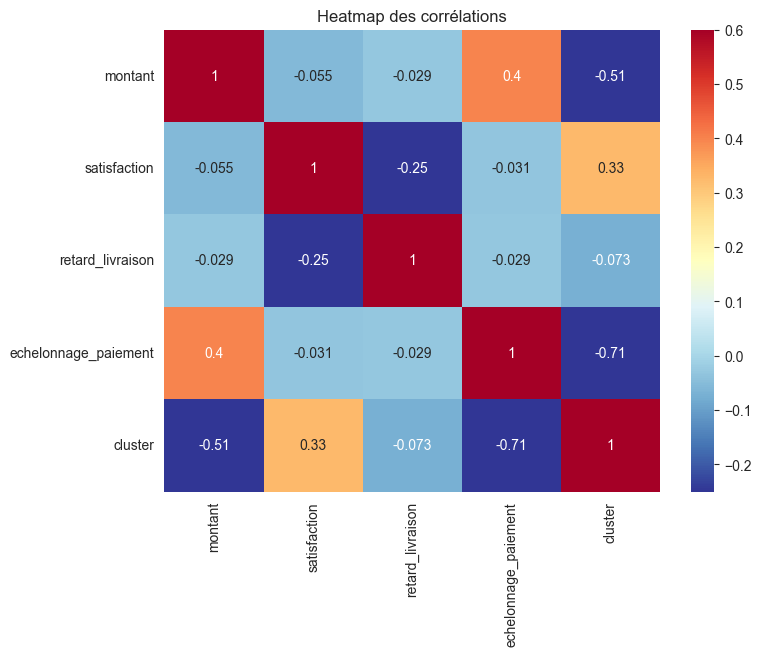

In [61]:
plt.figure(figsize = (8, 6))
data_corr = data_msle_norm.select_dtypes(include=['float', 'int32'])
# Heatmap des correlations
sns.heatmap(data_corr.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Heatmap des corrélations');

Dans ce clustering K-Means à 2 clusters RFMS, on visualise que la fréquence est la variable la plus corrélée aux clusters. La corrélation est négative (plus la fréquence a une valeur haute, plus le cluster a une valeur basse) et très importante.

NameError: name 'data_rfms_norm' is not defined

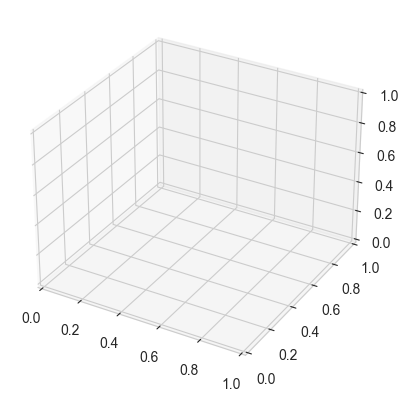

In [62]:
# Visualisation des résultats en 3D sans la satisfaction en axe
fig=plt.figure()
ax=fig.add_subplot(111,projection='3d')
ax.scatter(data_rfms_norm['Frequence'],data_rfms_norm['recence'],data_rfms_norm['montant'],c=data_rfms_norm['cluster'],cmap='viridis')
ax.set_xlabel('Frequence')
ax.set_ylabel('recence')
ax.set_zlabel('montant')
ax.set_title('RFMS Clustering à 2 clusters')
plt.show()

In [ ]:
# range_n_clusters = [2, 3, 4, 5]

# for n_clusters in range_n_clusters:
#     # Creation des graphiques 1 lignes, 3 colonnes
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     fig.set_size_inches(18, 7)

#     # Premier graphique : score de silhouette par cluster
#     # Le coefficient de silhouette peut aller de -1, 1 mais on le fera de [-0.1, 1]
#     ax1.set_xlim([-0.1, 1])
#     #  (n_clusters+1)*10 pour insérer un espace pour démarquer les clusters
#     ax1.set_ylim([0, len(data_rfm_norm) + (n_clusters + 1) * 10])

#     # Clustering
#     clusterer = KMeans(n_clusters=n_clusters,init='k-means++',n_init=10,max_iter=300,random_state=42)
#     cluster_labels = clusterer.fit_predict(data_rfm_norm)

#     # Calcul des scores de silhouette
#     silhouette_avg = silhouette_score(data_rfm_norm, cluster_labels)
#     print(
#         "Pour n_clusters =",
#         n_clusters,
#         "Le score de silhouette moyen est de:",
#         silhouette_avg,
#     )

#     # Calcul du score de silhouette pour chaque échantillon
#     sample_silhouette_values = silhouette_samples(data_rfm_norm, cluster_labels)

#     y_lower = 10
#     for i in range(n_clusters):
#         ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

#         ith_cluster_silhouette_values.sort()

#         size_cluster_i = ith_cluster_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i

#         color = cm.nipy_spectral(float(i) / n_clusters)
#         ax1.fill_betweenx(
#             np.arange(y_lower, y_upper),
#             0,
#             ith_cluster_silhouette_values,
#             facecolor=color,
#             edgecolor=color,
#             alpha=0.7,
#         )

#         # Titre du graphiques et étiquettes
#         ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

#         y_lower = y_upper + 10  # 10 for the 0 samples

#     ax1.set_title("Score de silhouette par clusters.")
#     ax1.set_xlabel("Coefficient de silhouette")
#     ax1.set_ylabel("Clusters")

#     # Ligne verticale pour le score de silhouette moyen
#     ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

#     ax1.set_yticks([])
#     ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

#     # Deuxième graphique : clusters formés selon les deux premières variables "fréquence" et "recence"
#     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
#     ax2 = fig.add_subplot(1, 2, 2, projection='3d')
#     ax2.scatter(
#         data_rfm_norm['Frequence'],
#         data_rfm_norm['recence'],
#         data_rfm_norm['montant'],
#         c=colors,
#         marker='o',
#         alpha=0.7,
#         edgecolor='k',
#         s=30
#     )

#     ax2.set_title("Cluster en 3D.")
#     ax2.set_xlabel('Fréquence')
#     ax2.set_ylabel('Recence')
#     ax2.set_zlabel('Montant')

#     plt.suptitle(
#         "Analyse du score de Silhouette après le clustering KMeans avec n_clusters = %d"
#         % n_clusters,
#         fontsize=14,
#         fontweight="bold",
#     )

# plt.show()

In [ ]:
# range_n_clusters = [2, 3, 4, 5]

# for n_clusters in range_n_clusters:
#     # Creation des graphiques 1 lignes, 3 colonnes
#     fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
#     fig.set_size_inches(18, 7)

#     # Premier graphique : score de silhouette par cluster
#     # Le coefficient de silhouette peut aller de -1, 1 mais on le fera de [-0.1, 1]
#     ax1.set_xlim([-0.1, 1])
#     #  (n_clusters+1)*10 pour insérer un espace pour démarquer les clusters
#     ax1.set_ylim([0, len(data_rfm_norm) + (n_clusters + 1) * 10])

#     # Clustering
#     clusterer = KMeans(n_clusters=n_clusters,init='k-means++',n_init=10,max_iter=300,random_state=42)
#     cluster_labels = clusterer.fit_predict(data_rfm_norm)

#     # Calcul des scores de silhouette
#     silhouette_avg = silhouette_score(data_rfm_norm, cluster_labels)
#     print(
#         "Pour n_clusters =",
#         n_clusters,
#         "Le score de silhouette moyen est de:",
#         silhouette_avg,
#     )

#     # Calcul du score de silhouette pour chaque échantillon
#     sample_silhouette_values = silhouette_samples(data_rfm_norm, cluster_labels)

#     y_lower = 10
#     for i in range(n_clusters):
#         ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

#         ith_cluster_silhouette_values.sort()

#         size_cluster_i = ith_cluster_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i

#         color = cm.nipy_spectral(float(i) / n_clusters)
#         ax1.fill_betweenx(
#             np.arange(y_lower, y_upper),
#             0,
#             ith_cluster_silhouette_values,
#             facecolor=color,
#             edgecolor=color,
#             alpha=0.7,
#         )

#         # Titre du graphiques et étiquettes
#         ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

#         y_lower = y_upper + 10  # 10 for the 0 samples

#     ax1.set_title("Score de silhouette par clusters.")
#     ax1.set_xlabel("Coefficient de silhouette")
#     ax1.set_ylabel("Clusters")

#     # Ligne verticale pour le score de silhouette moyen
#     ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

#     ax1.set_yticks([])
#     ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

#     # Deuxième graphique : clusters formés selon les deux premières variables "fréquence" et "recence"
#     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
#     ax2.scatter(
#         data_rfm_norm['Frequence'], data_rfm_norm['recence'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
#     )

#     # Calcul des centres de clusters
#     centers = clusterer.cluster_centers_
#     # Cercles blancs pour les centres de clusters
#     ax2.scatter(
#         centers[:, 0],
#         centers[:, 1],
#         marker="o",
#         c="white",
#         alpha=1,
#         s=200,
#         edgecolor="k",
#     )

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

#     ax2.set_title("Cluster selon les deux premières variables.")
#     ax2.set_xlabel("Frequence")
#     ax2.set_ylabel("recence")

#     plt.suptitle(
#         "Analyse du score de Silhouette après le clustering KMeans avec n_clusters = %d"
#         % n_clusters,
#         fontsize=14,
#         fontweight="bold",
#     )

#     # Deuxième graphique : clusters formés selon les variables "fréquence" et "montant"
#     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
#     ax3.scatter(
#         data_rfm_norm['Frequence'], data_rfm_norm['montant'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
#     )
#      # Calcul des centres de clusters
#     centers = clusterer.cluster_centers_
#     # Cercles blancs pour les centres de clusters
#     ax3.scatter(
#         centers[:, 0],
#         centers[:, 2],
#         marker="o",
#         c="white",
#         alpha=1,
#         s=200,
#         edgecolor="k",
#     )
#     for i, c in enumerate(centers):
#         ax3.scatter(c[2], c[3], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

#     ax3.set_title("Cluster selon les deux premières variables.")
#     ax3.set_xlabel("Frequence")
#     ax3.set_ylabel("montant")

#     plt.suptitle(
#         "Analyse du score de Silhouette après le clustering KMeans avec n_clusters = %d"
#         % n_clusters,
#         fontsize=14,
#         fontweight="bold",
#     )
# plt.show()